In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import os
import time
import math
import random
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import AutoModel, AutoTokenizer
from captum.attr import LayerIntegratedGradients
from openai import OpenAI

from language_training_utils import *

# import language_training_utils
# importlib.reload(language_training_utils)
# from language_training_utils import *

# Language Clustering

Clustering experiments with text feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

'descricao' token-length statistics:
Min: 2; Max: 420; 
Mean: 56.91137187559626; std: 35.49477155731764; 
Mode: ModeResult(mode=33, count=380); 
Q1: 32.0; 
Q2: 49.0; 
Q3: 73.0;
How many sentences longer than 128 tokens? 856



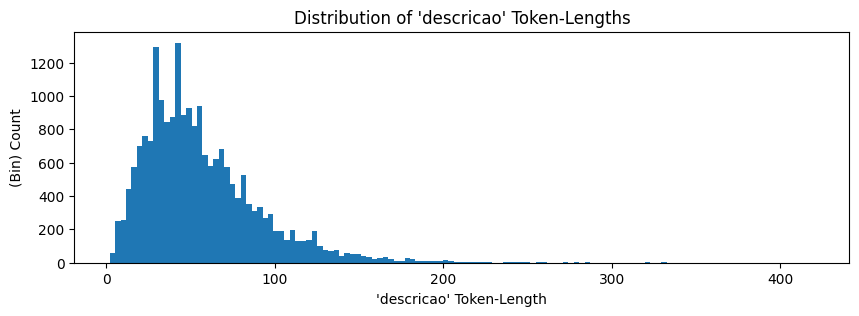

In [4]:
# Studying the distribution of sentence token-lengths on dataframe 'descricao' to make a 
# decision regarding the max sequence length to use for models (also with memory restrictions)
sentence_list = list(ind_df['descricao'].dropna())
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', \
                                          do_lower_case=False)
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in sentence_list]
token_lengths = np.array(token_lengths)

# Printing statistics and finding out that, given the small amount of sentences with more than
# 128 tokens, maybe we don't need to run an entire LLM pipeline to reduce sentence lengths. 
# Having said that, sequence length of 64 is pretty tight and would make us lose around 30%
# of our data with no LLM pipeline to reduce sentences
print("'descricao' token-length statistics:")
print(f"""Min: {np.min(token_lengths)}; Max: {np.max(token_lengths)}; 
Mean: {np.mean(token_lengths)}; std: {np.std(token_lengths)}; 
Mode: {stats.mode(token_lengths)}; 
Q1: {np.quantile(token_lengths, 0.25)}; 
Q2: {np.quantile(token_lengths, 0.50)}; 
Q3: {np.quantile(token_lengths, 0.75)};""")
print(f"How many sentences longer than 128 tokens? {len(np.where(token_lengths > 128)[0])}\n")

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of 'descricao' Token-Lengths")
plt.show()

Due to the very small amount of sentences with more than 128 tokens, and to the fact that, even those, are normally very close to 128 tokens, we first decided to postpone the bulding of an LLM pipeline to summarize longer sentences. Having said that, because of the bad quality of embeddings we got, we later decided to try reducing the sentences to more key aspects of it.

In [5]:
# Defining chucnk_size because we use it later
chunk_size = 20

In [6]:
%%skip

# Concatenating the descriptions an then mapping them to file splits for later API request
for i in range(0, len(sentence_list), chunk_size):
    chunk = sentence_list[i:i+chunk_size]
    file_num = i//chunk_size + 1
    file_name = f"sentences_{file_num}.txt"
    file_path = os.path.join('../data/raw_descriptions', file_name)

    # Removing unwanted line breaks in the middle of the sentences to prevent broken pipeline
    for j, description in enumerate(chunk):
        chunk[j] = description.replace('\n', '. ')
    
    # Write the chunk to file, one sentence per line
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(chunk))

In [7]:
# Function to load files
def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

In [8]:
%%skip

# Initializing API client
groq_key = load_file('../data/groq').strip()
os.environ['OPENAI_API_KEY'] = groq_key
client = OpenAI(
    base_url='https://api.groq.com/openai/v1',
    api_key=os.environ['OPENAI_API_KEY'],
)

# Going through sentences, making request for LLM model and rewriting them
for file in tqdm(os.listdir('../data/raw_descriptions')):
    if 'sentences' not in file:
        continue
    descriptions = load_file(os.path.join('../data/raw_descriptions', file))

    # Keep trying inspite of internal server errors
    try_counter = 0
    while True:
        try:
            response = client.chat.completions.create(
                model='meta-llama/llama-4-maverick-17b-128e-instruct',
                messages=[
                    {
                        'role': 'system',
                        'content': "Para CADA linha do texto (mesmo repetida), gere uma versão reduzida em até 62 tokens, preservando sentido e palavras chaves. Responda com exatamente todas as linhas reduzidas, na mesma ordem, sem introdução.",
                    },
                    {
                        'role': 'user',
                        'content': f'{descriptions}',
                    },
                ],
                temperature=0.3,
                max_tokens=8192,
            )

            # Writing new sentences, but checking for the correct number of (summarized)
            # sentences first
            new_sentences = response.choices[0].message.content.strip()

            if len(new_sentences.split('\n')) != chunk_size and try_counter < 5:
                # So we don't overload the server
                try_counter += 1
                time.sleep(2)
                continue
            
            else:
                try_counter = 0
                with open(os.path.join('../data/summarized_descriptions', file), \
                          'w', encoding='utf-8') as f:
                    f.write(new_sentences)
                break
        
        except Exception as e:
            print(file)
            print(f'Server problem... {e}')
            time.sleep(15)
    
    # Don't exceeed API's (free) limit
    time.sleep(2)

In [9]:
# Checking the files that don't have the exact chunk_size number of descriptions to manually
# fix them
for file in [i for i in os.listdir('../data/summarized_descriptions') if 'sentences' in i]:
    descriptions = load_file(os.path.join('../data/summarized_descriptions', file))
    if len(descriptions.strip().split('\n')) != chunk_size:
        descriptions = descriptions.strip().split('\n')
        print(f"{file} -> {len(descriptions)}")

sentences_1049.txt -> 4


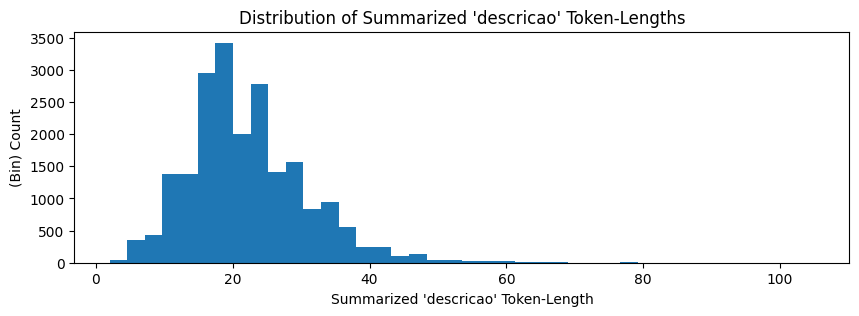

In [10]:
# Helper function to sort by the numeric suffix
def extract_index(file):
    return int(file.split('_')[-1].split('.')[0])

# Getting all (summarized) sentences in proper order
files = glob('../data/summarized_descriptions/sentences_*.txt')
files = sorted(files, key=extract_index)

summarized_sentence_list = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        lines = [line.strip().lower() for line in f if line.strip()]
        summarized_sentence_list.extend(lines)

# Creating column with summarized sentences
ind_df['descricao_resumida'] = ''
ind_df.loc[ind_df['descricao'].isna(), 'descricao_resumida'] = pd.NA
ind_df.loc[ind_df['descricao'].notna(), 'descricao_resumida'] = summarized_sentence_list

# Reanalyzing token distribution in sentences
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in summarized_sentence_list]
token_lengths = np.array(token_lengths)

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("Summarized 'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of Summarized 'descricao' Token-Lengths")
plt.show()

In [11]:
%%skip

# Generating a dataset of positive and negative examples for the contrastive learning using 
# LLMs (so that we don't need to rely on dropout noise for contrastive signal)
for file in tqdm(os.listdir('../data/summarized_descriptions')):
    if 'sentences' not in file:
        continue
    descriptions = load_file(os.path.join('../data/summarized_descriptions', file))

    # Keep trying inspite of internal server errors
    try_counter = 0
    while True:
        try:
            response = client.chat.completions.create(
                model='meta-llama/llama-4-maverick-17b-128e-instruct',
                messages=[
                    {
                        'role': 'system',
                        'content': f"Uma lista de frases será fornecida, uma por linha. Para CADA linha faça duas tarefas: gere uma paráfrase com até 62 tokens e escolha uma outra frase da lista que é a semanticamente mais diferente da frase alvo. Sua resposta deve conter exatamente uma paráfrase e uma negativa para CADA frase original. O formato deve ser 'positivo: <paráfrase> \n negativo: <negativa> \n\n' para cada frase. Não responda mais nada.",
                    },
                    {
                        'role': 'user',
                        'content': f'{descriptions}',
                    },
                ],
                temperature=0.3,
                max_tokens=4096,
            )

            # Writing new sentences, but doing some processing first
            new_sentences = response.choices[0].message.content.strip()

            # Fixing file structure for the common case of no double line-break
            if len(new_sentences.strip().split('\n\n')) == 1:
                even = 0
                fixed_new_sentences = []
                for c in new_sentences.strip():
                    fixed_new_sentences.append(c)
                    if c == '\n':
                        if even:
                            fixed_new_sentences.append('\n')
                        even = 1 - even
                new_sentences = ''.join(fixed_new_sentences)
                        
            # Checking number of sentences
            if len(new_sentences.strip().split('\n\n')) != chunk_size and try_counter < 5:
                # So we don't overload the server
                try_counter += 1
                time.sleep(2)
                continue
            
            else:
                try_counter = 0
                with open(os.path.join('../data/contrastive_triplets', file), \
                          'w', encoding='utf-8') as f:
                    f.write(new_sentences)
                break
        
        except Exception as e:
            print(f'Server problem... {e}')
            time.sleep(15)
    
    # Don't exceeed API's (free) limit
    time.sleep(2)

In [12]:
# Checking the files that don't have the exact chunk_size number of contrastive descriptions
# to manually fix them
for file in [i for i in os.listdir('../data/contrastive_triplets') if 'sentences' in i]:
    descriptions = load_file(os.path.join('../data/contrastive_triplets', file))
    if len(descriptions.strip().split('\n\n')) != chunk_size:
        descriptions = descriptions.strip().split('\n\n')
        print(f"{file} -> {len(descriptions)}")

sentences_1049.txt -> 4


In [13]:
# Getting all (contrastive) sentences in proper order
files = glob('../data/contrastive_triplets/sentences_*.txt')
files = sorted(files, key=extract_index)

# Creating multi-negative contrastive dataset with positive sentences coming from triplets, 
# but negative sentences from other categories
positive_contrastive_sentence_list = []
single_negative_contrastive_sentence_list = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
        positive_contrastive_sentence_list.extend([line.replace('positivo: ', '').lower() \
                                                   for line in lines[::2]])
        single_negative_contrastive_sentence_list.extend(
                                                    [line.replace('negativo: ','').lower() \
                                                     for line in lines[1::2]]
                                                  )

# Creating columns for contrastive sentences
ind_df['positive_contrastive'] = ''
ind_df.loc[ind_df['descricao_resumida'].isna(), 'positive_contrastive'] = pd.NA
ind_df.loc[ind_df['descricao_resumida'].notna(), \
           'positive_contrastive'] = positive_contrastive_sentence_list

ind_df['single_negative_contrastive'] = ''
ind_df.loc[ind_df['descricao_resumida'].isna(), 'single_negative_contrastive'] = pd.NA
ind_df.loc[ind_df['descricao_resumida'].notna(), \
           'single_negative_contrastive'] = single_negative_contrastive_sentence_list

# For multi-negative, we are going to find 5 sentences from other categories
ind_df['multi_negative_contrastive'] = ''
ind_df.loc[ind_df['descricao_resumida'].isna(), 'multi_negative_contrastive'] = pd.NA

# Creating dictionary of samples to make sampling faster
sampling_dict = {c: ind_df.loc[(ind_df['categoria'] != c) & \
                               (ind_df['descricao_resumida'].notna()), \
                               'descricao_resumida'] for c in ind_df['categoria'].unique()}

# Iterating the dataframe and sampling from other 'categoria'
n_samples = 10
for index, row in ind_df.loc[ind_df['descricao_resumida'].notna()].iterrows():
    current_categoria = row['categoria']
    sampled_list = sampling_dict[current_categoria].sample(n=n_samples, replace=False).tolist()
    ind_df.at[index, 'multi_negative_contrastive'] = sampled_list

## BERTimbau

### Vanilla Model

In [14]:
# Getting device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [15]:
# Initializing model, turning it into eval mode and zeroing out the gradients
# base_model = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased')
base_model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
base_model = base_model.to(device)
base_model.eval()
base_model.zero_grad()

# Getting sentences' dataset, dataloader and splits
text_ind_df = ind_df[~ind_df['descricao_resumida'].isna()]
max_length = 64
text_dataset = UnsupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 64
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

# Computing baseline embedding
baseline_input_ids, \
baseline_embedding = get_baseline_embedding(tokenizer.pad_token_id, tokenizer.cls_token_id, \
                                            tokenizer.sep_token_id, max_length, base_model, \
                                            device, fine_tuned=False)

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(base_model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, base_model.embeddings)

In [16]:
# Checking model's STS-B score for reference
_ = stsb_test(base_model, device, tokenizer, max_length=max_length, model_loss='vanilla', \
              verbose=True, train_split=False)

# Checking model's in-context STS-B score for reference too
subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(base_model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='vanilla', verbose=True, train_split=False)

STS-B (Pearson): 0.6927
In-Context STS-B (Pearson): 0.7451


In [17]:
# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_bertimbau_indices = []
vanilla_bertimbau_embeddings = []
vanilla_bertimbau_tokens = []
vanilla_bertimbau_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    vanilla_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(base_model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_bertimbau_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1))
    vanilla_bertimbau_tokens.append(tokens)
    vanilla_bertimbau_attributions.append(attributions)
    
# Concatenating the batches
vanilla_bertimbau_indices = np.array(vanilla_bertimbau_indices).squeeze(-1)
vanilla_bertimbau_embeddings = np.array(torch.cat(vanilla_bertimbau_embeddings, dim=0))
vanilla_bertimbau_tokens = np.array(vanilla_bertimbau_tokens)
vanilla_bertimbau_attributions = np.array(torch.cat(vanilla_bertimbau_attributions, dim=0))

100%|██████████████████| 20964/20964 [1:07:57<00:00,  5.14it/s]


In [18]:
# Getting data projections
vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap = data_projections(vanilla_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_bertimbau_trimap = normalize(vanilla_bertimbau_trimap, norm_factor)
vanilla_bertimbau_tsne = normalize(vanilla_bertimbau_tsne, norm_factor)
vanilla_bertimbau_umap = normalize(vanilla_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

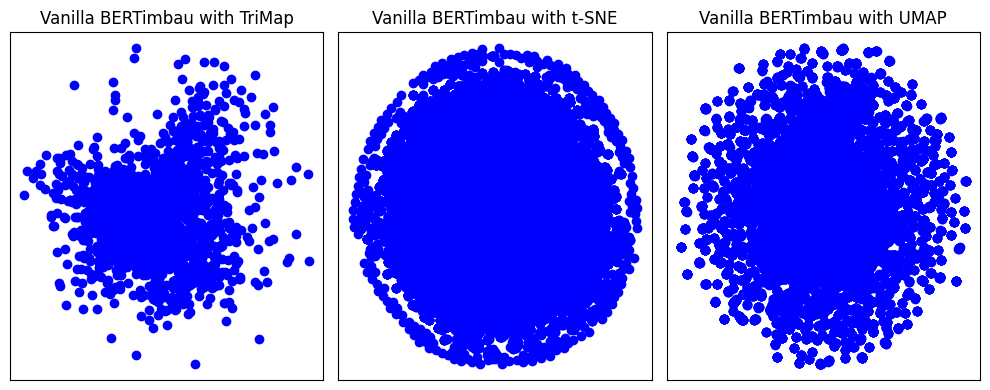

In [19]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=1, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(10,4))
# plt.suptitle('Comparing Projections of BERTimbau Models')

# Plotting vanilla BERTimbau projections
projs = [vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, vanilla_bertimbau_umap]
proj_names = ['Vanilla BERTimbau with TriMap', 'Vanilla BERTimbau with t-SNE', \
              'Vanilla BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [20]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_bertimbau_umap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_umap.csv')

In [21]:
# Cleaning memory
clean_mem([vanilla_bertimbau_embeddings, vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap, vanilla_bertimbau_attributions, vanilla_bertimbau_indices])

### Unsupervised SimCSE (Contrastive Learning with no Labels)

----- TEMPERATURA 0.05 -----


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0969 | Val Loss: 0.0110 | STS-B: 0.7492 | In-Context STS-B: 0.8552


Epoch:  12%|██▉                    | 1/8 [03:14<22:39, 194.14s/it]

New best model found!


Epoch:  25%|█████▊                 | 2/8 [06:27<19:20, 193.49s/it]

Epoch 2/8 | Train Loss: 0.0189 | Val Loss: 0.0085 | STS-B: 0.7447 | In-Context STS-B: 0.8583


Epoch:  38%|████████▋              | 3/8 [09:40<16:06, 193.25s/it]

Epoch 3/8 | Train Loss: 0.0122 | Val Loss: 0.0072 | STS-B: 0.7395 | In-Context STS-B: 0.8605


Epoch:  50%|███████████▌           | 4/8 [12:53<12:52, 193.20s/it]

Epoch 4/8 | Train Loss: 0.0098 | Val Loss: 0.0067 | STS-B: 0.7350 | In-Context STS-B: 0.8605


Epoch:  62%|██████████████▍        | 5/8 [16:05<09:38, 192.90s/it]

Epoch 5/8 | Train Loss: 0.0101 | Val Loss: 0.0063 | STS-B: 0.7299 | In-Context STS-B: 0.8601


Epoch:  75%|█████████████████▎     | 6/8 [19:18<06:25, 192.83s/it]

Epoch 6/8 | Train Loss: 0.0092 | Val Loss: 0.0054 | STS-B: 0.7290 | In-Context STS-B: 0.8610


Epoch:  88%|████████████████████▏  | 7/8 [22:31<03:12, 192.84s/it]

Epoch 7/8 | Train Loss: 0.0099 | Val Loss: 0.0053 | STS-B: 0.7267 | In-Context STS-B: 0.8627


Epoch: 100%|███████████████████████| 8/8 [25:44<00:00, 193.01s/it]

Epoch 8/8 | Train Loss: 0.0079 | Val Loss: 0.0052 | STS-B: 0.7209 | In-Context STS-B: 0.8582


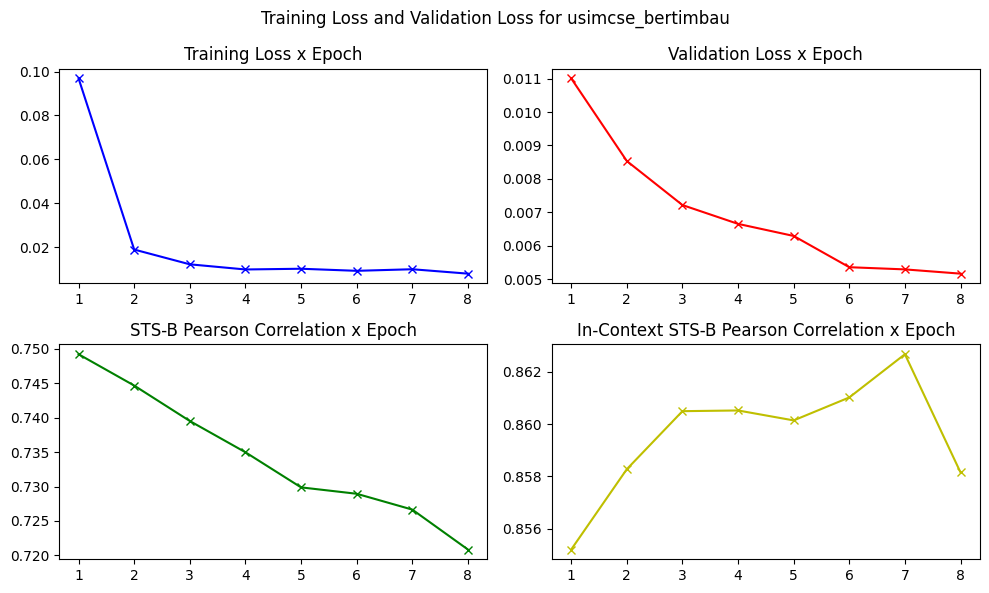

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7103
In-Context STS-B (Pearson): 0.8510
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0962 | Val Loss: 0.0109 | STS-B: 0.7475 | In-Context STS-B: 0.8547


Epoch:  12%|██▉                    | 1/8 [03:14<22:42, 194.68s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0183 | Val Loss: 0.0083 | STS-B: 0.7439 | In-Context STS-B: 0.8592


Epoch:  25%|█████▊                 | 2/8 [06:29<19:27, 194.57s/it]

New best model found!


Epoch:  38%|████████▋              | 3/8 [09:41<16:08, 193.74s/it]

Epoch 3/8 | Train Loss: 0.0150 | Val Loss: 0.0068 | STS-B: 0.7391 | In-Context STS-B: 0.8575


Epoch:  50%|███████████▌           | 4/8 [12:54<12:53, 193.32s/it]

Epoch 4/8 | Train Loss: 0.0113 | Val Loss: 0.0064 | STS-B: 0.7326 | In-Context STS-B: 0.8559


Epoch:  62%|██████████████▍        | 5/8 [16:07<09:39, 193.15s/it]

Epoch 5/8 | Train Loss: 0.0091 | Val Loss: 0.0059 | STS-B: 0.7304 | In-Context STS-B: 0.8565


Epoch:  75%|█████████████████▎     | 6/8 [19:20<06:26, 193.06s/it]

Epoch 6/8 | Train Loss: 0.0076 | Val Loss: 0.0057 | STS-B: 0.7281 | In-Context STS-B: 0.8523


Epoch:  88%|████████████████████▏  | 7/8 [22:33<03:13, 193.05s/it]

Epoch 7/8 | Train Loss: 0.0091 | Val Loss: 0.0055 | STS-B: 0.7262 | In-Context STS-B: 0.8536


Epoch: 100%|███████████████████████| 8/8 [25:46<00:00, 193.31s/it]

Epoch 8/8 | Train Loss: 0.0089 | Val Loss: 0.0053 | STS-B: 0.7251 | In-Context STS-B: 0.8524


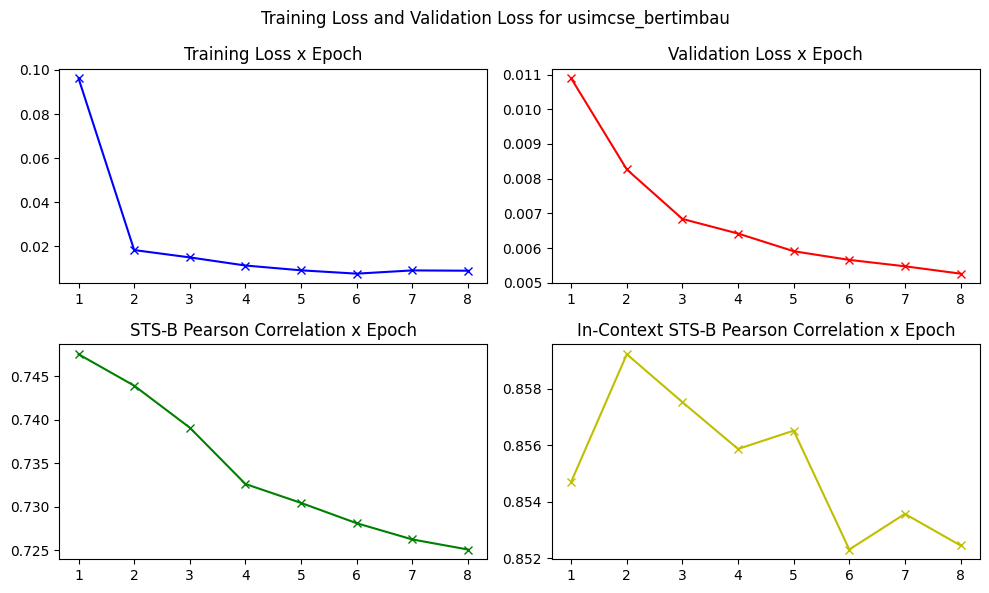

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7060
In-Context STS-B (Pearson): 0.8548
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0969 | Val Loss: 0.0111 | STS-B: 0.7473 | In-Context STS-B: 0.8563


Epoch:  12%|██▉                    | 1/8 [03:14<22:41, 194.45s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0170 | Val Loss: 0.0082 | STS-B: 0.7458 | In-Context STS-B: 0.8599


Epoch:  25%|█████▊                 | 2/8 [06:29<19:27, 194.63s/it]

New best model found!


Epoch:  38%|████████▋              | 3/8 [09:42<16:10, 194.08s/it]

Epoch 3/8 | Train Loss: 0.0138 | Val Loss: 0.0070 | STS-B: 0.7387 | In-Context STS-B: 0.8595


Epoch:  50%|███████████▌           | 4/8 [12:55<12:54, 193.52s/it]

Epoch 4/8 | Train Loss: 0.0111 | Val Loss: 0.0063 | STS-B: 0.7325 | In-Context STS-B: 0.8574


Epoch:  62%|██████████████▍        | 5/8 [16:08<09:39, 193.29s/it]

Epoch 5/8 | Train Loss: 0.0091 | Val Loss: 0.0059 | STS-B: 0.7291 | In-Context STS-B: 0.8560


Epoch:  75%|█████████████████▎     | 6/8 [19:21<06:26, 193.24s/it]

Epoch 6/8 | Train Loss: 0.0093 | Val Loss: 0.0059 | STS-B: 0.7304 | In-Context STS-B: 0.8607


Epoch:  88%|████████████████████▏  | 7/8 [22:34<03:13, 193.23s/it]

Epoch 7/8 | Train Loss: 0.0080 | Val Loss: 0.0056 | STS-B: 0.7243 | In-Context STS-B: 0.8582


Epoch: 100%|███████████████████████| 8/8 [25:47<00:00, 193.42s/it]

Epoch 8/8 | Train Loss: 0.0090 | Val Loss: 0.0054 | STS-B: 0.7206 | In-Context STS-B: 0.8582


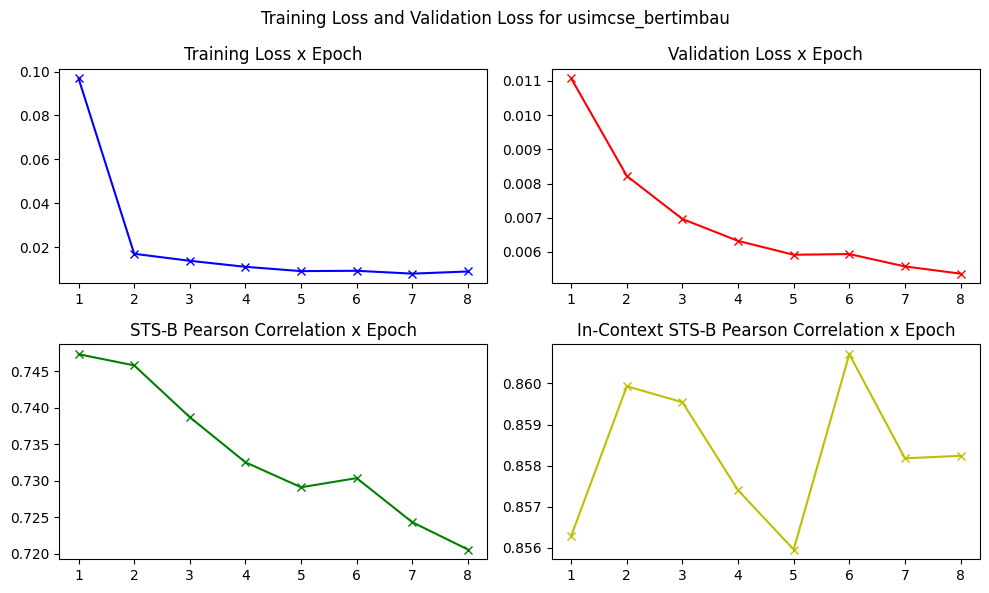

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7046
In-Context STS-B (Pearson): 0.8555
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.4978 | Val Loss: 0.0754 | STS-B: 0.7708 | In-Context STS-B: 0.8632


Epoch:  12%|██▉                    | 1/8 [03:14<22:40, 194.37s/it]

New best model found!


Epoch:  25%|█████▊                 | 2/8 [06:27<19:21, 193.62s/it]

Epoch 2/8 | Train Loss: 0.1285 | Val Loss: 0.0519 | STS-B: 0.7639 | In-Context STS-B: 0.8670


Epoch:  38%|████████▋              | 3/8 [09:40<16:05, 193.19s/it]

Epoch 3/8 | Train Loss: 0.0986 | Val Loss: 0.0470 | STS-B: 0.7614 | In-Context STS-B: 0.8671


Epoch:  50%|███████████▌           | 4/8 [12:53<12:52, 193.08s/it]

Epoch 4/8 | Train Loss: 0.0879 | Val Loss: 0.0442 | STS-B: 0.7584 | In-Context STS-B: 0.8642


Epoch:  62%|██████████████▍        | 5/8 [16:05<09:38, 192.91s/it]

Epoch 5/8 | Train Loss: 0.0819 | Val Loss: 0.0414 | STS-B: 0.7583 | In-Context STS-B: 0.8629


Epoch:  75%|█████████████████▎     | 6/8 [19:18<06:25, 192.81s/it]

Epoch 6/8 | Train Loss: 0.0787 | Val Loss: 0.0403 | STS-B: 0.7573 | In-Context STS-B: 0.8626


Epoch:  88%|████████████████████▏  | 7/8 [22:31<03:12, 192.94s/it]

Epoch 7/8 | Train Loss: 0.0728 | Val Loss: 0.0395 | STS-B: 0.7562 | In-Context STS-B: 0.8595


Epoch: 100%|███████████████████████| 8/8 [25:44<00:00, 193.04s/it]

Epoch 8/8 | Train Loss: 0.0695 | Val Loss: 0.0384 | STS-B: 0.7578 | In-Context STS-B: 0.8596


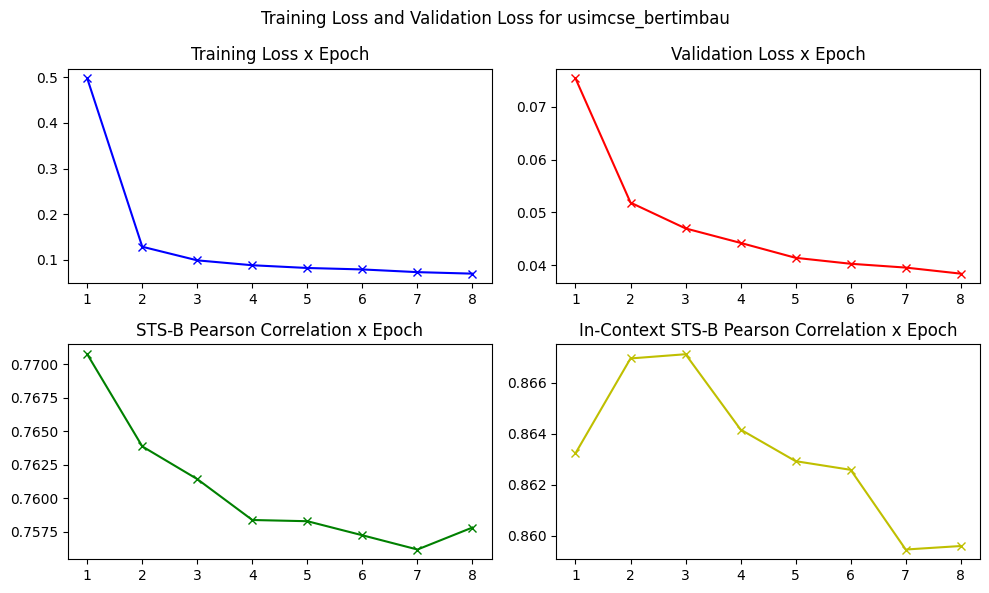

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7239
In-Context STS-B (Pearson): 0.8596
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.4984 | Val Loss: 0.0744 | STS-B: 0.7711 | In-Context STS-B: 0.8634


Epoch:  12%|██▉                    | 1/8 [03:14<22:39, 194.19s/it]

New best model found!


Epoch:  25%|█████▊                 | 2/8 [06:29<19:30, 195.06s/it]

Epoch 2/8 | Train Loss: 0.1289 | Val Loss: 0.0526 | STS-B: 0.7635 | In-Context STS-B: 0.8670


Epoch:  38%|████████▋              | 3/8 [09:47<16:21, 196.20s/it]

Epoch 3/8 | Train Loss: 0.1012 | Val Loss: 0.0470 | STS-B: 0.7615 | In-Context STS-B: 0.8677


Epoch:  50%|███████████▌           | 4/8 [13:06<13:08, 197.15s/it]

Epoch 4/8 | Train Loss: 0.0893 | Val Loss: 0.0439 | STS-B: 0.7600 | In-Context STS-B: 0.8675


Epoch:  62%|██████████████▍        | 5/8 [16:24<09:52, 197.61s/it]

Epoch 5/8 | Train Loss: 0.0836 | Val Loss: 0.0418 | STS-B: 0.7568 | In-Context STS-B: 0.8633


Epoch:  75%|█████████████████▎     | 6/8 [19:42<06:35, 197.84s/it]

Epoch 6/8 | Train Loss: 0.0775 | Val Loss: 0.0407 | STS-B: 0.7563 | In-Context STS-B: 0.8634


Epoch:  88%|████████████████████▏  | 7/8 [23:01<03:18, 198.13s/it]

Epoch 7/8 | Train Loss: 0.0743 | Val Loss: 0.0396 | STS-B: 0.7554 | In-Context STS-B: 0.8601


Epoch: 100%|███████████████████████| 8/8 [26:19<00:00, 197.44s/it]

Epoch 8/8 | Train Loss: 0.0698 | Val Loss: 0.0387 | STS-B: 0.7570 | In-Context STS-B: 0.8596


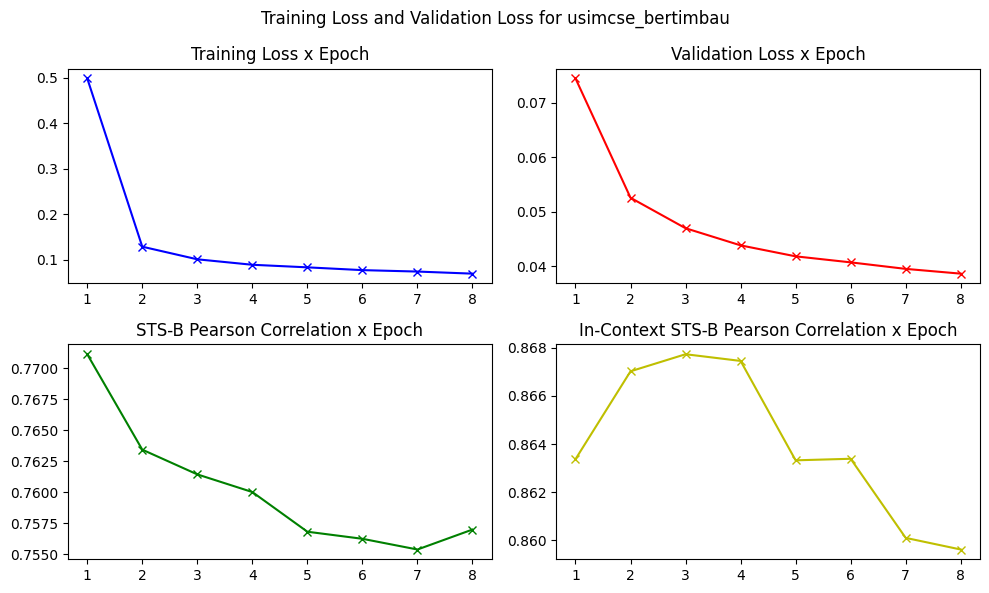

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7242
In-Context STS-B (Pearson): 0.8599
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                             | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.4957 | Val Loss: 0.0735 | STS-B: 0.7711 | In-Context STS-B: 0.8636


Epoch:  12%|██▌                 | 1/8 [03:19<23:15, 199.32s/it]

New best model found!


Epoch:  25%|█████               | 2/8 [06:32<19:34, 195.70s/it]

Epoch 2/8 | Train Loss: 0.1267 | Val Loss: 0.0526 | STS-B: 0.7647 | In-Context STS-B: 0.8676


Epoch:  38%|███████▌            | 3/8 [09:45<16:12, 194.43s/it]

Epoch 3/8 | Train Loss: 0.1004 | Val Loss: 0.0471 | STS-B: 0.7599 | In-Context STS-B: 0.8665


Epoch:  50%|██████████          | 4/8 [12:58<12:55, 193.89s/it]

Epoch 4/8 | Train Loss: 0.0909 | Val Loss: 0.0440 | STS-B: 0.7593 | In-Context STS-B: 0.8660


Epoch:  62%|████████████▌       | 5/8 [16:11<09:40, 193.64s/it]

Epoch 5/8 | Train Loss: 0.0819 | Val Loss: 0.0416 | STS-B: 0.7589 | In-Context STS-B: 0.8656


Epoch:  75%|███████████████     | 6/8 [19:25<06:27, 193.57s/it]

Epoch 6/8 | Train Loss: 0.0765 | Val Loss: 0.0412 | STS-B: 0.7571 | In-Context STS-B: 0.8619


Epoch:  88%|█████████████████▌  | 7/8 [22:38<03:13, 193.45s/it]

Epoch 7/8 | Train Loss: 0.0721 | Val Loss: 0.0392 | STS-B: 0.7568 | In-Context STS-B: 0.8607


Epoch: 100%|████████████████████| 8/8 [25:51<00:00, 193.94s/it]

Epoch 8/8 | Train Loss: 0.0682 | Val Loss: 0.0388 | STS-B: 0.7560 | In-Context STS-B: 0.8581


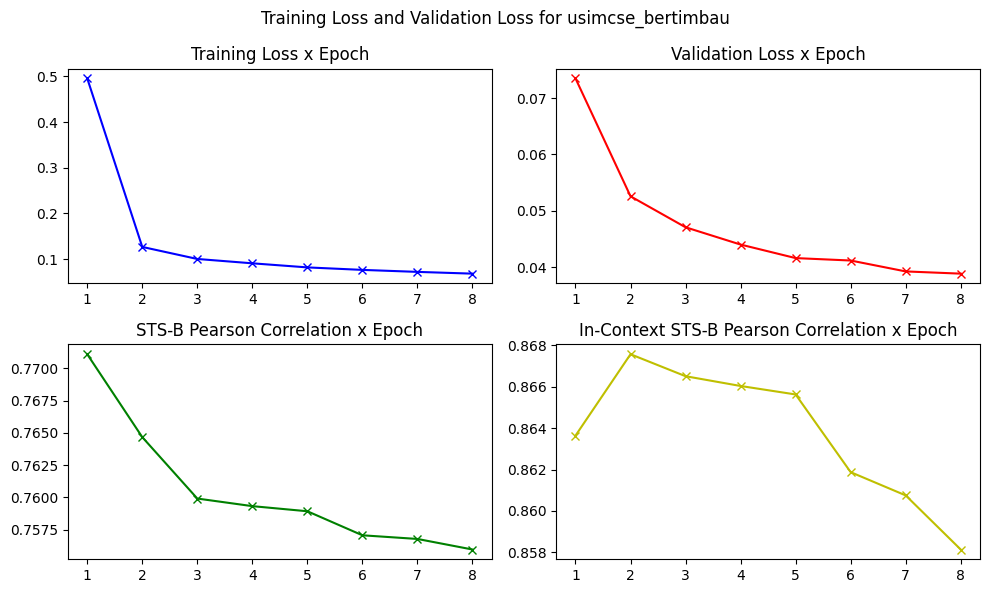

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7242
In-Context STS-B (Pearson): 0.8608
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 1.8304 | Val Loss: 1.0887 | STS-B: 0.7813 | In-Context STS-B: 0.8548


Epoch:  12%|██▉                    | 1/8 [03:14<22:42, 194.65s/it]

New best model found!
Epoch 2/8 | Train Loss: 1.3045 | Val Loss: 1.0348 | STS-B: 0.7823 | In-Context STS-B: 0.8626


Epoch:  25%|█████▊                 | 2/8 [06:28<19:26, 194.36s/it]

New best model found!


Epoch:  38%|████████▋              | 3/8 [09:42<16:09, 193.89s/it]

Epoch 3/8 | Train Loss: 1.2390 | Val Loss: 1.0178 | STS-B: 0.7812 | In-Context STS-B: 0.8614


Epoch:  50%|███████████▌           | 4/8 [12:54<12:53, 193.46s/it]

Epoch 4/8 | Train Loss: 1.2038 | Val Loss: 1.0077 | STS-B: 0.7787 | In-Context STS-B: 0.8609


Epoch:  62%|██████████████▍        | 5/8 [16:07<09:39, 193.21s/it]

Epoch 5/8 | Train Loss: 1.1787 | Val Loss: 0.9990 | STS-B: 0.7765 | In-Context STS-B: 0.8587


Epoch:  75%|█████████████████▎     | 6/8 [19:20<06:26, 193.05s/it]

Epoch 6/8 | Train Loss: 1.1588 | Val Loss: 0.9885 | STS-B: 0.7741 | In-Context STS-B: 0.8576


Epoch:  88%|████████████████████▏  | 7/8 [22:33<03:13, 193.05s/it]

Epoch 7/8 | Train Loss: 1.1426 | Val Loss: 0.9844 | STS-B: 0.7699 | In-Context STS-B: 0.8559


Epoch: 100%|███████████████████████| 8/8 [25:46<00:00, 193.32s/it]

Epoch 8/8 | Train Loss: 1.1305 | Val Loss: 0.9802 | STS-B: 0.7654 | In-Context STS-B: 0.8545


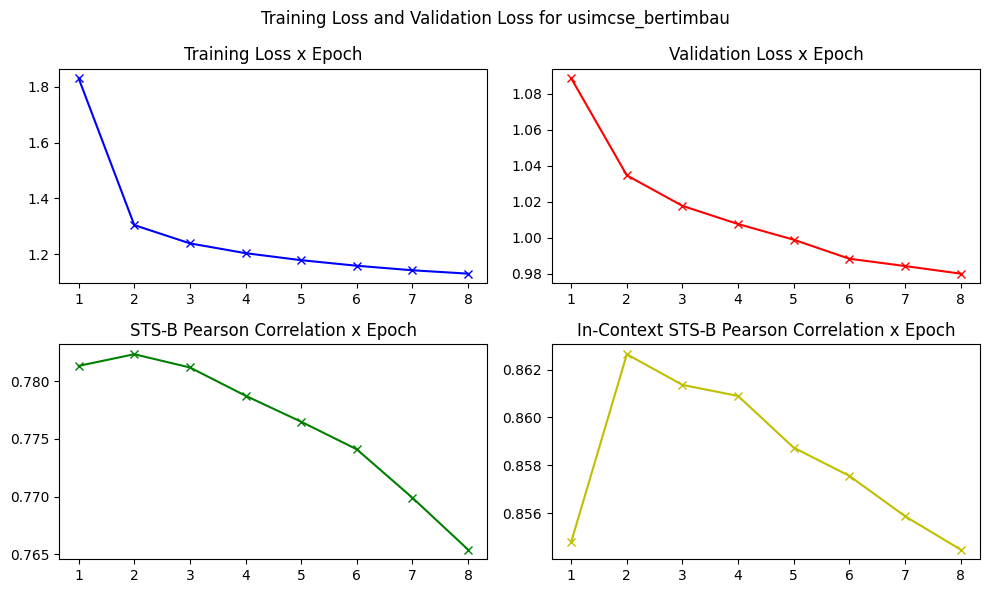

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7397
In-Context STS-B (Pearson): 0.8596
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 1.8321 | Val Loss: 1.0828 | STS-B: 0.7827 | In-Context STS-B: 0.8555


Epoch:  12%|██▉                    | 1/8 [03:14<22:41, 194.52s/it]

New best model found!
Epoch 2/8 | Train Loss: 1.3038 | Val Loss: 1.0372 | STS-B: 0.7833 | In-Context STS-B: 0.8613


Epoch:  25%|█████▊                 | 2/8 [06:29<19:27, 194.58s/it]

New best model found!


Epoch:  38%|████████▋              | 3/8 [09:42<16:09, 193.84s/it]

Epoch 3/8 | Train Loss: 1.2371 | Val Loss: 1.0154 | STS-B: 0.7820 | In-Context STS-B: 0.8609


Epoch:  50%|███████████▌           | 4/8 [12:55<12:54, 193.64s/it]

Epoch 4/8 | Train Loss: 1.2010 | Val Loss: 1.0057 | STS-B: 0.7808 | In-Context STS-B: 0.8597


Epoch:  62%|██████████████▍        | 5/8 [16:08<09:40, 193.37s/it]

Epoch 5/8 | Train Loss: 1.1784 | Val Loss: 0.9967 | STS-B: 0.7782 | In-Context STS-B: 0.8584


Epoch:  75%|█████████████████▎     | 6/8 [19:20<06:26, 193.10s/it]

Epoch 6/8 | Train Loss: 1.1600 | Val Loss: 0.9905 | STS-B: 0.7744 | In-Context STS-B: 0.8555


Epoch:  88%|████████████████████▏  | 7/8 [22:34<03:13, 193.14s/it]

Epoch 7/8 | Train Loss: 1.1437 | Val Loss: 0.9812 | STS-B: 0.7708 | In-Context STS-B: 0.8545


Epoch: 100%|███████████████████████| 8/8 [25:47<00:00, 193.38s/it]

Epoch 8/8 | Train Loss: 1.1292 | Val Loss: 0.9780 | STS-B: 0.7676 | In-Context STS-B: 0.8523


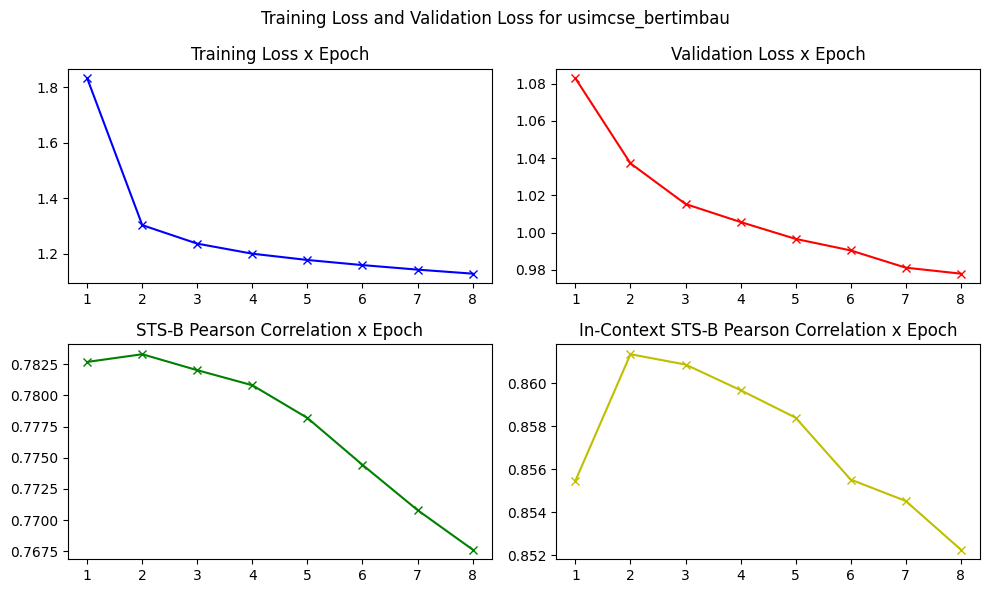

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7403
In-Context STS-B (Pearson): 0.8594
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7603


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 1.8328 | Val Loss: 1.0813 | STS-B: 0.7834 | In-Context STS-B: 0.8564


Epoch:  12%|██▉                    | 1/8 [03:14<22:40, 194.33s/it]

New best model found!
Epoch 2/8 | Train Loss: 1.3032 | Val Loss: 1.0326 | STS-B: 0.7841 | In-Context STS-B: 0.8620


Epoch:  25%|█████▊                 | 2/8 [06:29<19:28, 194.69s/it]

New best model found!


Epoch:  38%|████████▋              | 3/8 [09:42<16:09, 193.88s/it]

Epoch 3/8 | Train Loss: 1.2386 | Val Loss: 1.0197 | STS-B: 0.7825 | In-Context STS-B: 0.8613


Epoch:  50%|███████████▌           | 4/8 [12:55<12:54, 193.58s/it]

Epoch 4/8 | Train Loss: 1.2030 | Val Loss: 1.0074 | STS-B: 0.7794 | In-Context STS-B: 0.8595


Epoch:  62%|██████████████▍        | 5/8 [16:08<09:39, 193.33s/it]

Epoch 5/8 | Train Loss: 1.1783 | Val Loss: 0.9950 | STS-B: 0.7771 | In-Context STS-B: 0.8594


Epoch:  75%|█████████████████▎     | 6/8 [19:21<06:26, 193.25s/it]

Epoch 6/8 | Train Loss: 1.1582 | Val Loss: 0.9881 | STS-B: 0.7737 | In-Context STS-B: 0.8575


Epoch:  88%|████████████████████▏  | 7/8 [22:34<03:13, 193.18s/it]

Epoch 7/8 | Train Loss: 1.1451 | Val Loss: 0.9869 | STS-B: 0.7692 | In-Context STS-B: 0.8548


Epoch: 100%|███████████████████████| 8/8 [25:46<00:00, 193.37s/it]

Epoch 8/8 | Train Loss: 1.1297 | Val Loss: 0.9777 | STS-B: 0.7651 | In-Context STS-B: 0.8520


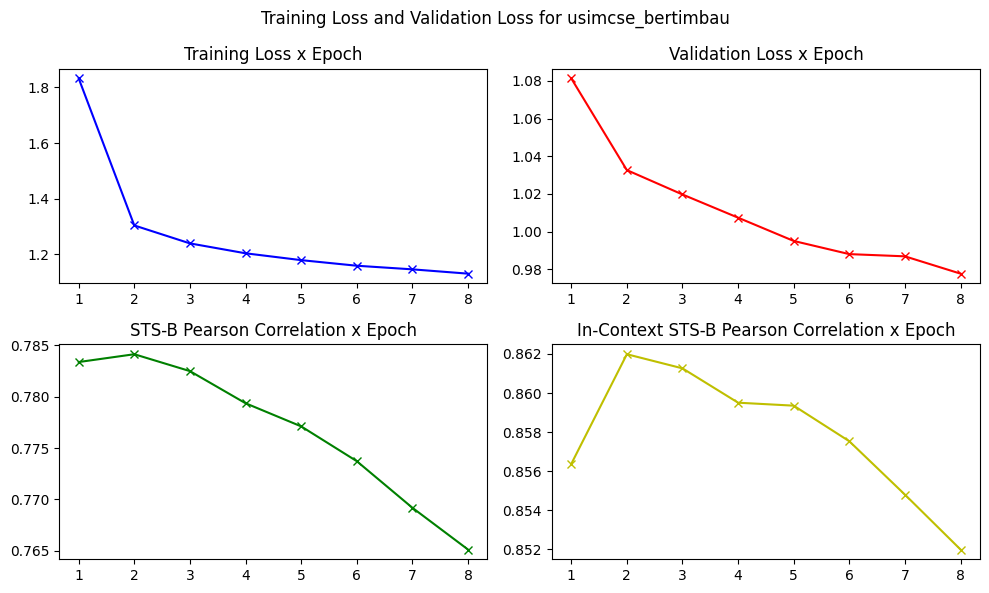

/tmp/ipykernel_1397029/3628982096.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7416
In-Context STS-B (Pearson): 0.8606


In [22]:
# Testing multiple times with multiple temperatures to better evaluate model's performance
# temperatures = [0.05 for i in range(3)] + [0.1 for i in range(3)] + [0.2 for i in range(3)]

# for temp in temperatures:
#     print(f'----- TEMPERATURA {temp} -----')
    
# Restarting baseline model so not to get the already fine-tuned from previous method or run
base_model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Initializing USimCSE model and auxiliar variables
dropout_prob = 0.1
model = USimCSEModel(base_model, tokenizer.pad_token_id, device, dropout_prob)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)
epochs = 8
temperature = 0.3
patience = max(2, math.ceil(epochs*0.1))
model_name = 'usimcse_bertimbau'
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
usimcse_indices, usimcse_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = usimcse_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='usimcse', \
              verbose=True, train_split=False)
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='usimcse', verbose=True, train_split=False)

In [23]:
# Recomputing baseline embedding for fine-tuned model
baseline_input_ids, \
baseline_embedding = get_baseline_embedding(tokenizer.pad_token_id, tokenizer.cls_token_id, \
                                            tokenizer.sep_token_id, max_length, model, \
                                            device, fine_tuned=True)

# Instanciating attribution computation class for fine-tuned model
usimcse_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
usimcse_wrapped_model.eval()
lig = LayerIntegratedGradients(usimcse_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
usimcse_bertimbau_indices = []
usimcse_bertimbau_embeddings = []
usimcse_bertimbau_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    usimcse_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    usimcse_bertimbau_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    usimcse_bertimbau_attributions.append(attributions)

# Concatenating the batches
usimcse_bertimbau_indices = np.array(usimcse_bertimbau_indices).squeeze(-1)
usimcse_bertimbau_embeddings = np.array(torch.cat(usimcse_bertimbau_embeddings, dim=0))
usimcse_bertimbau_attributions = np.array(torch.cat(usimcse_bertimbau_attributions, dim=0))

100%|█████████████████████| 20964/20964 [1:07:23<00:00,  5.18it/s]


In [24]:
# Getting data projections
usimcse_bertimbau_trimap, usimcse_bertimbau_tsne, \
usimcse_bertimbau_umap = data_projections(usimcse_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
usimcse_bertimbau_trimap = normalize(usimcse_bertimbau_trimap, norm_factor)
usimcse_bertimbau_tsne = normalize(usimcse_bertimbau_tsne, norm_factor)
usimcse_bertimbau_umap = normalize(usimcse_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


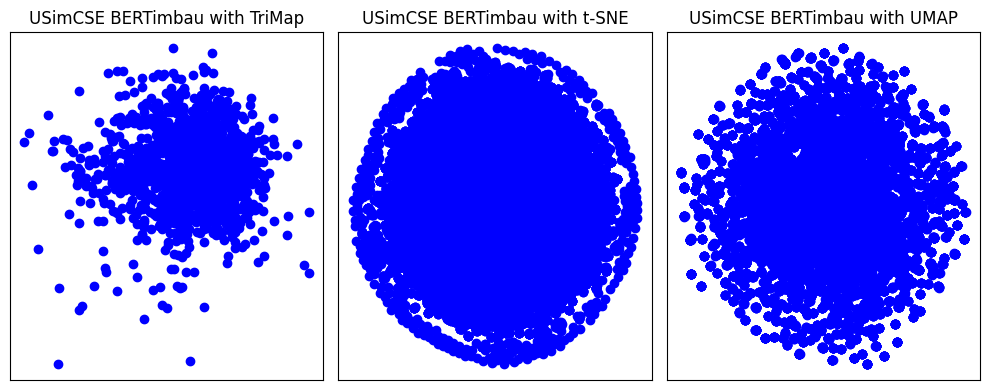

In [25]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting USimCSE BERTimbau projections
projs = [usimcse_bertimbau_trimap, usimcse_bertimbau_tsne, usimcse_bertimbau_umap]
proj_names = ['USimCSE BERTimbau with TriMap', 'USimCSE BERTimbau with t-SNE', \
              'USimCSE BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [26]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(usimcse_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   usimcse_bertimbau_attributions, usimcse_bertimbau_indices, \
                   save_file='usimcse_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(usimcse_bertimbau_umap, vanilla_bertimbau_tokens, \
                   usimcse_bertimbau_attributions, usimcse_bertimbau_indices, \
                   save_file='usimcse_bertimbau_umap.csv')

In [27]:
# Cleaning memory
clean_mem([usimcse_bertimbau_embeddings, usimcse_bertimbau_trimap, usimcse_bertimbau_tsne, \
usimcse_bertimbau_umap, usimcse_bertimbau_attributions, usimcse_bertimbau_indices])

###  Supervised InfoNCE (Contrastive Learning with Labels)

----- TEMPERATURA 0.05 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7490


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0309 | Val Loss: 0.0138 | STS-B: 0.7890 | In-Context STS-B: 0.8514


Epoch:  12%|██▌                 | 1/8 [18:50<2:11:52, 1130.40s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0053 | Val Loss: 0.0086 | STS-B: 0.7990 | In-Context STS-B: 0.8533


Epoch:  25%|█████               | 2/8 [37:40<1:53:02, 1130.37s/it]

New best model found!
Epoch 3/8 | Train Loss: 0.0012 | Val Loss: 0.0057 | STS-B: 0.8028 | In-Context STS-B: 0.8537


Epoch:  38%|███████▌            | 3/8 [56:30<1:34:10, 1130.04s/it]

New best model found!
Epoch 4/8 | Train Loss: 0.0007 | Val Loss: 0.0054 | STS-B: 0.8028 | In-Context STS-B: 0.8559


Epoch:  50%|█████████         | 4/8 [1:15:20<1:15:19, 1129.90s/it]

New best model found!
Epoch 5/8 | Train Loss: 0.0005 | Val Loss: 0.0057 | STS-B: 0.8103 | In-Context STS-B: 0.8580


Epoch:  62%|████████████▌       | 5/8 [1:34:11<56:31, 1130.49s/it]

New best model found!


Epoch:  75%|███████████████     | 6/8 [1:53:03<37:41, 1130.80s/it]

Epoch 6/8 | Train Loss: 0.0002 | Val Loss: 0.0049 | STS-B: 0.8104 | In-Context STS-B: 0.8571


Epoch:  88%|█████████████████▌  | 7/8 [2:11:54<18:51, 1131.08s/it]

Epoch 7/8 | Train Loss: 0.0002 | Val Loss: 0.0049 | STS-B: 0.8112 | In-Context STS-B: 0.8567
Epoch 8/8 | Train Loss: 0.0001 | Val Loss: 0.0046 | STS-B: 0.8111 | In-Context STS-B: 0.8586


Epoch: 100%|████████████████████| 8/8 [2:30:48<00:00, 1131.08s/it]

New best model found!


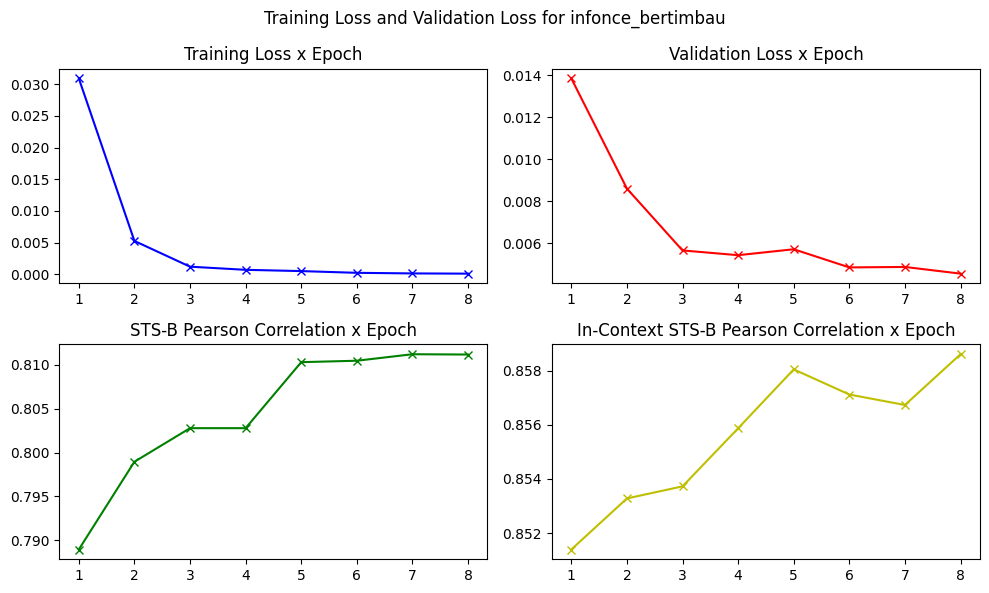

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7842
In-Context STS-B (Pearson): 0.8625
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7521


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0324 | Val Loss: 0.0128 | STS-B: 0.7846 | In-Context STS-B: 0.8453


Epoch:  12%|██▌                 | 1/8 [18:52<2:12:10, 1132.93s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0049 | Val Loss: 0.0065 | STS-B: 0.7845 | In-Context STS-B: 0.8482


Epoch:  25%|█████               | 2/8 [37:47<1:53:22, 1133.67s/it]

New best model found!
Epoch 3/8 | Train Loss: 0.0014 | Val Loss: 0.0057 | STS-B: 0.7926 | In-Context STS-B: 0.8519


Epoch:  38%|███████▌            | 3/8 [56:41<1:34:29, 1133.99s/it]

New best model found!


Epoch:  50%|█████████         | 4/8 [1:15:35<1:15:35, 1133.94s/it]

Epoch 4/8 | Train Loss: 0.0009 | Val Loss: 0.0052 | STS-B: 0.7912 | In-Context STS-B: 0.8528
Epoch 5/8 | Train Loss: 0.0004 | Val Loss: 0.0043 | STS-B: 0.7995 | In-Context STS-B: 0.8546


Epoch:  62%|████████████▌       | 5/8 [1:34:30<56:42, 1134.33s/it]

New best model found!


Epoch:  75%|███████████████     | 6/8 [1:53:24<37:48, 1134.22s/it]

Epoch 6/8 | Train Loss: 0.0003 | Val Loss: 0.0039 | STS-B: 0.7928 | In-Context STS-B: 0.8547
Epoch 7/8 | Train Loss: 0.0002 | Val Loss: 0.0042 | STS-B: 0.8014 | In-Context STS-B: 0.8536


Epoch:  88%|█████████████████▌  | 7/8 [2:12:19<18:54, 1134.49s/it]

New best model found!
Epoch 8/8 | Train Loss: 0.0002 | Val Loss: 0.0032 | STS-B: 0.8103 | In-Context STS-B: 0.8558


Epoch: 100%|████████████████████| 8/8 [2:31:13<00:00, 1134.23s/it]

New best model found!


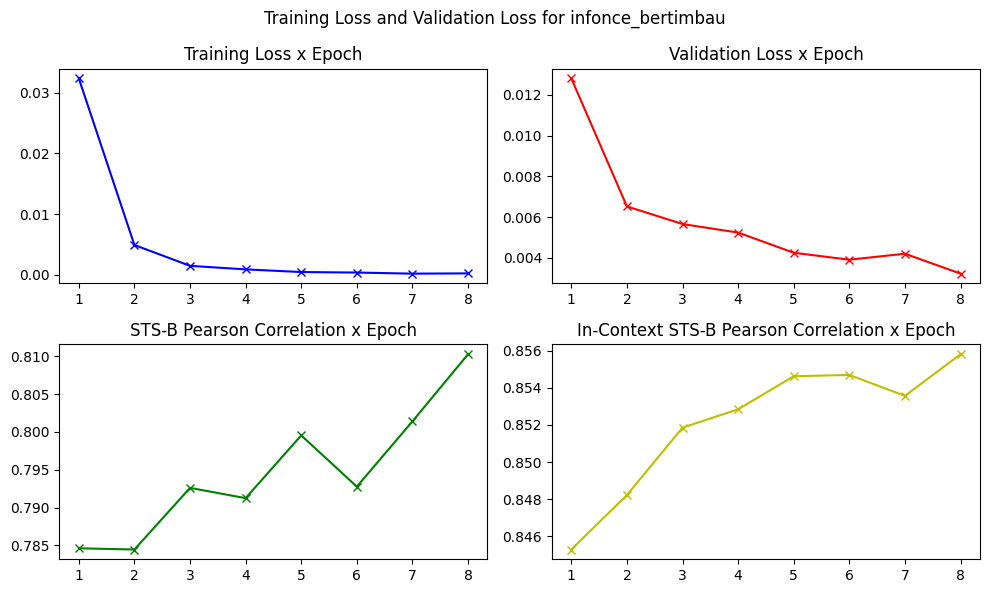

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7801
In-Context STS-B (Pearson): 0.8571
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7705


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0286 | Val Loss: 0.0145 | STS-B: 0.7888 | In-Context STS-B: 0.8657


Epoch:  12%|██▌                 | 1/8 [18:54<2:12:23, 1134.75s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0037 | Val Loss: 0.0100 | STS-B: 0.7979 | In-Context STS-B: 0.8695


Epoch:  25%|█████               | 2/8 [37:49<1:53:29, 1134.94s/it]

New best model found!
Epoch 3/8 | Train Loss: 0.0012 | Val Loss: 0.0084 | STS-B: 0.8010 | In-Context STS-B: 0.8704


Epoch:  38%|███████▌            | 3/8 [56:44<1:34:34, 1134.86s/it]

New best model found!
Epoch 4/8 | Train Loss: 0.0007 | Val Loss: 0.0087 | STS-B: 0.8088 | In-Context STS-B: 0.8707


Epoch:  50%|█████████         | 4/8 [1:15:38<1:15:38, 1134.56s/it]

New best model found!


Epoch:  62%|████████████▌       | 5/8 [1:34:31<56:42, 1134.02s/it]

Epoch 5/8 | Train Loss: 0.0004 | Val Loss: 0.0075 | STS-B: 0.8071 | In-Context STS-B: 0.8721
Epoch 6/8 | Train Loss: 0.0002 | Val Loss: 0.0073 | STS-B: 0.8128 | In-Context STS-B: 0.8732


Epoch:  75%|███████████████     | 6/8 [1:53:26<37:48, 1134.25s/it]

New best model found!
Epoch 7/8 | Train Loss: 0.0002 | Val Loss: 0.0075 | STS-B: 0.8161 | In-Context STS-B: 0.8742


Epoch:  88%|█████████████████▌  | 7/8 [2:12:20<18:54, 1134.15s/it]

New best model found!
Epoch 8/8 | Train Loss: 0.0001 | Val Loss: 0.0073 | STS-B: 0.8191 | In-Context STS-B: 0.8742


Epoch: 100%|████████████████████| 8/8 [2:31:14<00:00, 1134.31s/it]

New best model found!


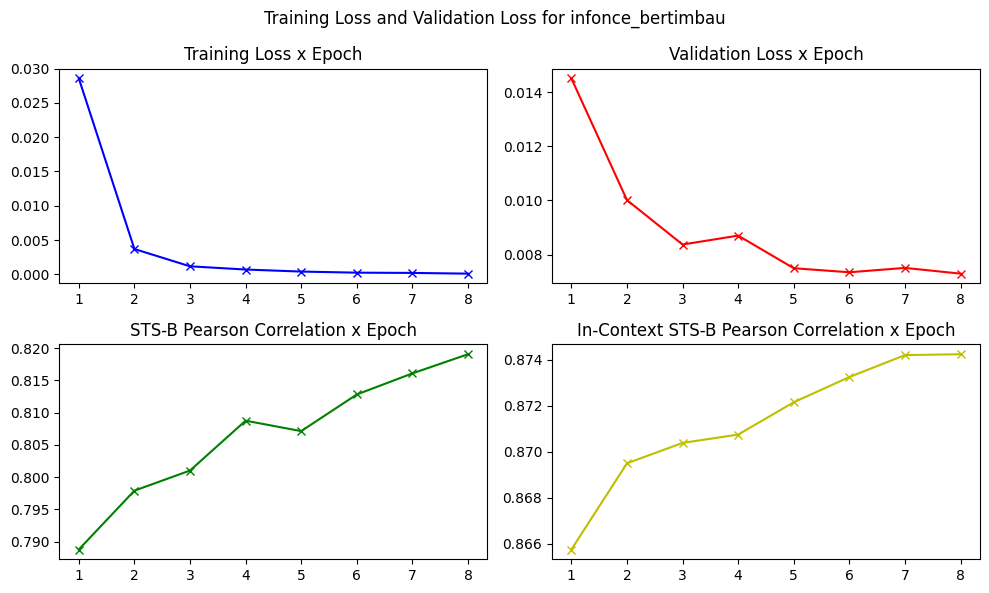

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7876
In-Context STS-B (Pearson): 0.8701
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7494


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0716 | Val Loss: 0.0080 | STS-B: 0.8162 | In-Context STS-B: 0.8470


Epoch:  12%|██▌                 | 1/8 [18:54<2:12:22, 1134.65s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0166 | Val Loss: 0.0067 | STS-B: 0.8205 | In-Context STS-B: 0.8474


Epoch:  25%|█████               | 2/8 [37:49<1:53:27, 1134.58s/it]

New best model found!
Epoch 3/8 | Train Loss: 0.0095 | Val Loss: 0.0053 | STS-B: 0.8249 | In-Context STS-B: 0.8474


Epoch:  38%|███████▌            | 3/8 [56:44<1:34:33, 1134.78s/it]

New best model found!


Epoch:  50%|█████████         | 4/8 [1:15:38<1:15:38, 1134.72s/it]

Epoch 4/8 | Train Loss: 0.0064 | Val Loss: 0.0047 | STS-B: 0.8223 | In-Context STS-B: 0.8454


Epoch:  62%|████████████▌       | 5/8 [1:34:33<56:44, 1134.72s/it]

Epoch 5/8 | Train Loss: 0.0046 | Val Loss: 0.0036 | STS-B: 0.8225 | In-Context STS-B: 0.8427


Epoch:  75%|███████████████     | 6/8 [1:53:29<37:50, 1135.19s/it]

Epoch 6/8 | Train Loss: 0.0035 | Val Loss: 0.0031 | STS-B: 0.8183 | In-Context STS-B: 0.8406


Epoch:  88%|█████████████████▌  | 7/8 [2:12:29<18:56, 1136.66s/it]

Epoch 7/8 | Train Loss: 0.0027 | Val Loss: 0.0031 | STS-B: 0.8179 | In-Context STS-B: 0.8382


Epoch: 100%|████████████████████| 8/8 [2:31:30<00:00, 1136.28s/it]

Epoch 8/8 | Train Loss: 0.0021 | Val Loss: 0.0034 | STS-B: 0.8195 | In-Context STS-B: 0.8332


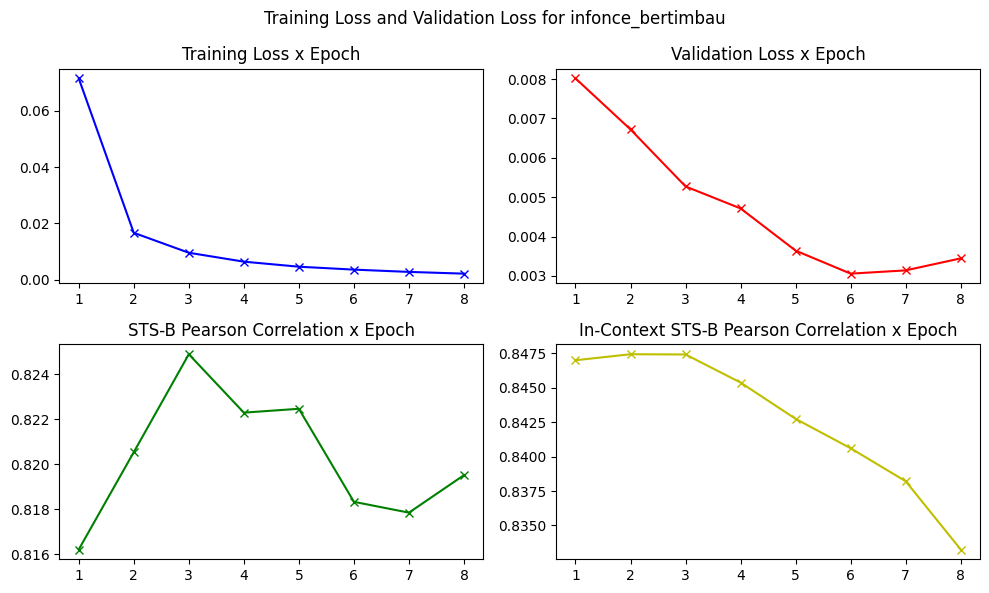

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7880
In-Context STS-B (Pearson): 0.8447
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7454


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0722 | Val Loss: 0.0046 | STS-B: 0.8166 | In-Context STS-B: 0.8395


Epoch:  12%|██▌                 | 1/8 [19:04<2:13:34, 1144.99s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0166 | Val Loss: 0.0040 | STS-B: 0.8213 | In-Context STS-B: 0.8391


Epoch:  25%|█████               | 2/8 [38:08<1:54:25, 1144.19s/it]

New best model found!


Epoch:  38%|███████▌            | 3/8 [57:08<1:35:11, 1142.36s/it]

Epoch 3/8 | Train Loss: 0.0092 | Val Loss: 0.0038 | STS-B: 0.8237 | In-Context STS-B: 0.8366


Epoch:  50%|█████████         | 4/8 [1:16:10<1:16:08, 1142.02s/it]

Epoch 4/8 | Train Loss: 0.0064 | Val Loss: 0.0035 | STS-B: 0.8231 | In-Context STS-B: 0.8352


Epoch:  62%|████████████▌       | 5/8 [1:35:12<57:05, 1141.92s/it]

Epoch 5/8 | Train Loss: 0.0045 | Val Loss: 0.0030 | STS-B: 0.8201 | In-Context STS-B: 0.8344


Epoch:  75%|███████████████     | 6/8 [1:54:11<38:02, 1141.04s/it]

Epoch 6/8 | Train Loss: 0.0033 | Val Loss: 0.0033 | STS-B: 0.8195 | In-Context STS-B: 0.8307


Epoch:  88%|█████████████████▌  | 7/8 [2:13:10<19:00, 1140.34s/it]

Epoch 7/8 | Train Loss: 0.0026 | Val Loss: 0.0032 | STS-B: 0.8190 | In-Context STS-B: 0.8246


Epoch: 100%|████████████████████| 8/8 [2:32:07<00:00, 1140.96s/it]

Epoch 8/8 | Train Loss: 0.0021 | Val Loss: 0.0036 | STS-B: 0.8180 | In-Context STS-B: 0.8201


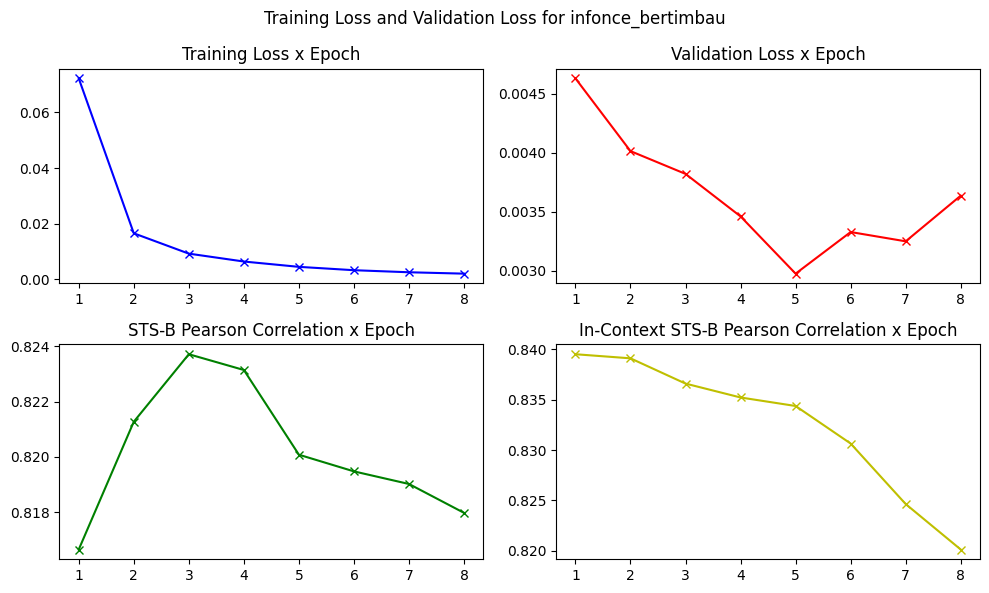

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7906
In-Context STS-B (Pearson): 0.8468
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7486


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.0661 | Val Loss: 0.0092 | STS-B: 0.8179 | In-Context STS-B: 0.8407


Epoch:  12%|██▌                 | 1/8 [18:54<2:12:20, 1134.40s/it]

New best model found!
Epoch 2/8 | Train Loss: 0.0155 | Val Loss: 0.0076 | STS-B: 0.8231 | In-Context STS-B: 0.8399


Epoch:  25%|█████               | 2/8 [37:49<1:53:29, 1134.89s/it]

New best model found!
Epoch 3/8 | Train Loss: 0.0090 | Val Loss: 0.0069 | STS-B: 0.8251 | In-Context STS-B: 0.8390


Epoch:  38%|███████▌            | 3/8 [56:45<1:34:37, 1135.48s/it]

New best model found!
Epoch 4/8 | Train Loss: 0.0061 | Val Loss: 0.0075 | STS-B: 0.8277 | In-Context STS-B: 0.8368


Epoch:  50%|█████████         | 4/8 [1:15:42<1:15:43, 1135.90s/it]

New best model found!


Epoch:  62%|████████████▌       | 5/8 [1:34:35<56:44, 1134.87s/it]

Epoch 5/8 | Train Loss: 0.0045 | Val Loss: 0.0061 | STS-B: 0.8262 | In-Context STS-B: 0.8336


Epoch:  75%|███████████████     | 6/8 [1:53:29<37:48, 1134.48s/it]

Epoch 6/8 | Train Loss: 0.0033 | Val Loss: 0.0062 | STS-B: 0.8234 | In-Context STS-B: 0.8320


Epoch:  88%|█████████████████▌  | 7/8 [2:12:25<18:55, 1135.06s/it]

Epoch 7/8 | Train Loss: 0.0026 | Val Loss: 0.0068 | STS-B: 0.8228 | In-Context STS-B: 0.8280


Epoch: 100%|████████████████████| 8/8 [2:31:21<00:00, 1135.14s/it]

Epoch 8/8 | Train Loss: 0.0020 | Val Loss: 0.0060 | STS-B: 0.8214 | In-Context STS-B: 0.8264


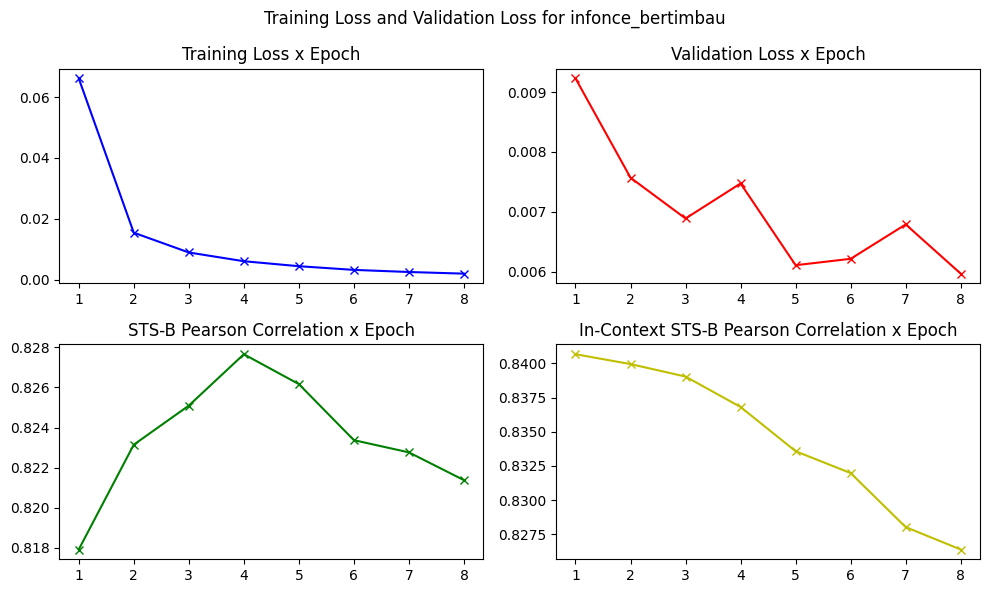

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7950
In-Context STS-B (Pearson): 0.8546
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7621


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.2442 | Val Loss: 0.0082 | STS-B: 0.8169 | In-Context STS-B: 0.8308


Epoch:  12%|██▌                 | 1/8 [18:55<2:12:30, 1135.76s/it]

New best model found!


Epoch:  25%|█████               | 2/8 [37:51<1:53:36, 1136.01s/it]

Epoch 2/8 | Train Loss: 0.1210 | Val Loss: 0.0062 | STS-B: 0.8066 | In-Context STS-B: 0.8171


Epoch:  38%|███████▌            | 3/8 [56:46<1:34:35, 1135.12s/it]

Epoch 3/8 | Train Loss: 0.0959 | Val Loss: 0.0100 | STS-B: 0.7945 | In-Context STS-B: 0.8007


Epoch:  38%|██████▊           | 3/8 [1:15:39<2:06:06, 1513.33s/it]

Epoch 4/8 | Train Loss: 0.0817 | Val Loss: 0.0098 | STS-B: 0.7899 | In-Context STS-B: 0.7958
Early stopping!


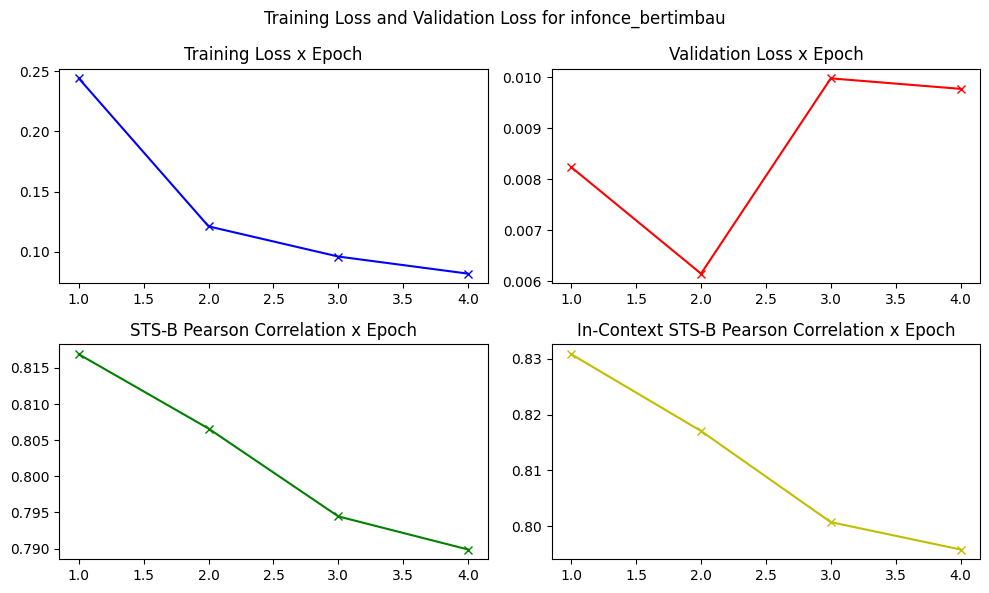

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7822
In-Context STS-B (Pearson): 0.8183
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7645


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.2509 | Val Loss: 0.0102 | STS-B: 0.8208 | In-Context STS-B: 0.8276


Epoch:  12%|██▌                 | 1/8 [18:55<2:12:25, 1135.01s/it]

New best model found!


Epoch:  25%|█████               | 2/8 [37:48<1:53:23, 1133.95s/it]

Epoch 2/8 | Train Loss: 0.1200 | Val Loss: 0.0088 | STS-B: 0.8131 | In-Context STS-B: 0.8144


Epoch:  38%|███████▌            | 3/8 [56:40<1:34:25, 1133.08s/it]

Epoch 3/8 | Train Loss: 0.0951 | Val Loss: 0.0069 | STS-B: 0.8083 | In-Context STS-B: 0.8031


Epoch:  38%|██████▊           | 3/8 [1:15:34<2:05:57, 1511.42s/it]

Epoch 4/8 | Train Loss: 0.0809 | Val Loss: 0.0056 | STS-B: 0.8035 | In-Context STS-B: 0.8022
Early stopping!


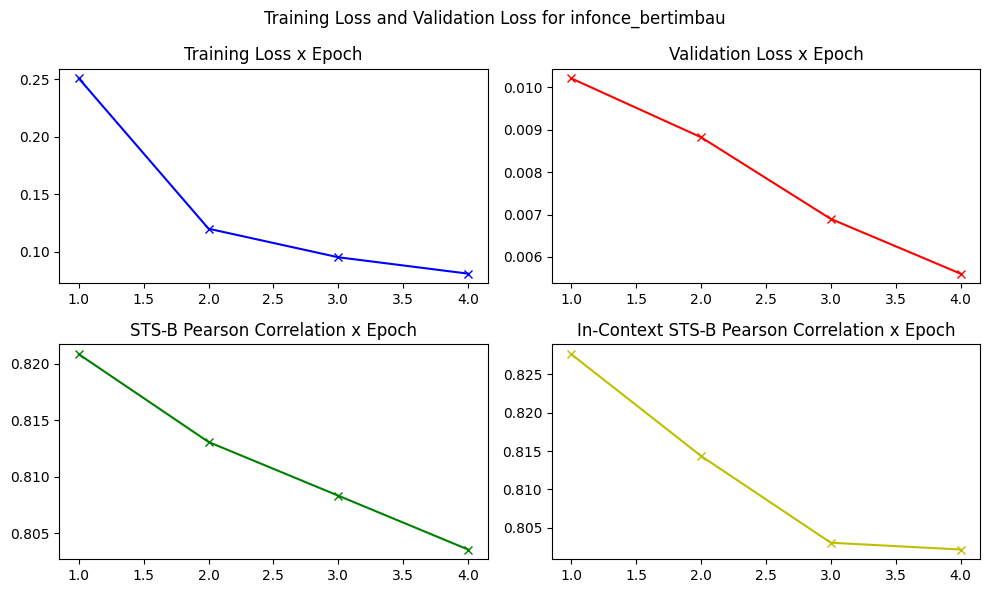

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7850
In-Context STS-B (Pearson): 0.8145
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.7103 | Initial In-Context STS-B: 0.7599


Epoch:   0%|                                | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.2462 | Val Loss: 0.0184 | STS-B: 0.8184 | In-Context STS-B: 0.8272


Epoch:  12%|██▌                 | 1/8 [18:53<2:12:17, 1133.95s/it]

New best model found!


Epoch:  25%|█████               | 2/8 [37:45<1:53:14, 1132.34s/it]

Epoch 2/8 | Train Loss: 0.1195 | Val Loss: 0.0167 | STS-B: 0.8085 | In-Context STS-B: 0.8127


Epoch:  38%|███████▌            | 3/8 [56:37<1:34:21, 1132.23s/it]

Epoch 3/8 | Train Loss: 0.0945 | Val Loss: 0.0149 | STS-B: 0.7996 | In-Context STS-B: 0.8030


Epoch:  38%|██████▊           | 3/8 [1:15:28<2:05:47, 1509.53s/it]

Epoch 4/8 | Train Loss: 0.0809 | Val Loss: 0.0128 | STS-B: 0.7927 | In-Context STS-B: 0.7973
Early stopping!


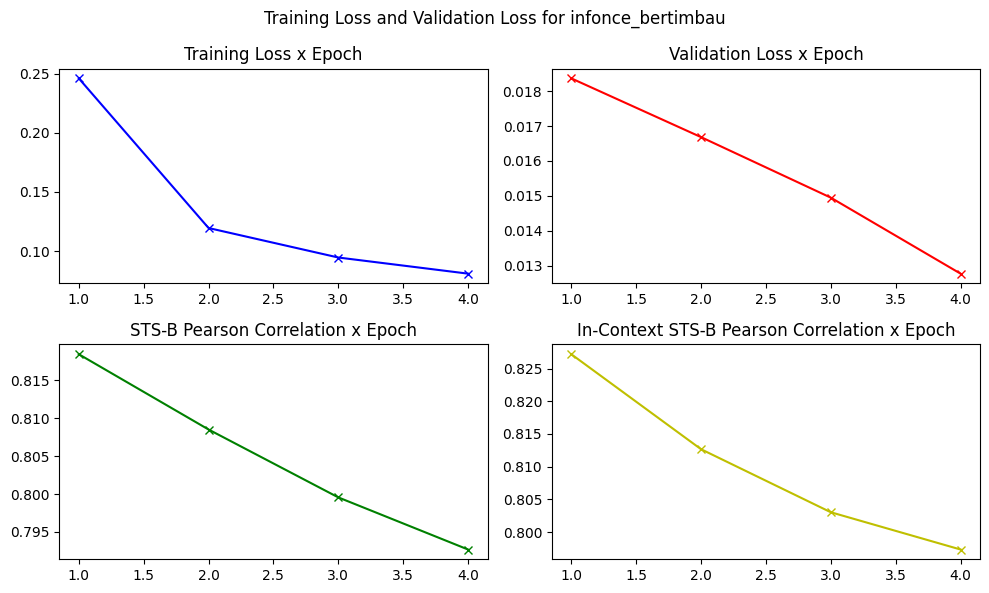

/tmp/ipykernel_1397029/2929085889.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7848
In-Context STS-B (Pearson): 0.8241


In [28]:
# Testing multiple times with multiple temperatures to better evaluate model's performance
# temperatures = [0.05 for i in range(3)] + [0.1 for i in range(3)] + [0.2 for i in range(3)]

# for temp in temperatures:
#     print(f'----- TEMPERATURA {temp} -----')
    
# Restarting baseline model so not to get the already fine-tuned from previous method or run
base_model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Initializing InfoNCEModel model and auxiliar variables
model = InfoNCEModel(base_model, tokenizer.pad_token_id, device, hidden_dim=768, proj_dim=768)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)
epochs = 12
temperature = 0.05
patience = max(2, math.ceil(epochs*0.1))
model_name = 'infonce_bertimbau'

# Getting sentences' dataset, dataloader and splits again (now for a supervised dataset)
max_length = 64
text_dataset = SupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)
split_batch_size = 8
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
infonce_indices, infonce_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = infonce_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='infonce', \
              verbose=True, train_split=False)

subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='infonce', verbose=True, train_split=False)

In [29]:
baseline_input_ids, \
baseline_embedding = get_baseline_embedding(tokenizer.pad_token_id, tokenizer.cls_token_id, \
                                            tokenizer.sep_token_id, max_length, model, \
                                            device, fine_tuned=True)

# Instanciating attribution computation class for fine-tuned model
infonce_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
infonce_wrapped_model.eval()
lig = LayerIntegratedGradients(infonce_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
infonce_bertimbau_indices = []
infonce_bertimbau_embeddings = []
infonce_bertimbau_attributions = []
for indices, anchor_ids, _, _ in tqdm(text_dataloader):
    # Saving indices
    infonce_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    anchor_ids = anchor_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, anchor_ids, device, fine_tuned=True)
    infonce_bertimbau_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, anchor_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    infonce_bertimbau_attributions.append(attributions)

# Concatenating the batches
infonce_bertimbau_indices = np.array(infonce_bertimbau_indices).squeeze(-1)
infonce_bertimbau_embeddings = np.array(torch.cat(infonce_bertimbau_embeddings, dim=0))
infonce_bertimbau_attributions = np.array(torch.cat(infonce_bertimbau_attributions, dim=0))

100%|█████████████████████| 20964/20964 [1:07:33<00:00,  5.17it/s]


In [30]:
# Getting data projections
infonce_bertimbau_trimap, infonce_bertimbau_tsne, \
infonce_bertimbau_umap = data_projections(infonce_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
infonce_bertimbau_trimap = normalize(infonce_bertimbau_trimap, norm_factor)
infonce_bertimbau_tsne = normalize(infonce_bertimbau_tsne, norm_factor)
infonce_bertimbau_umap = normalize(infonce_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

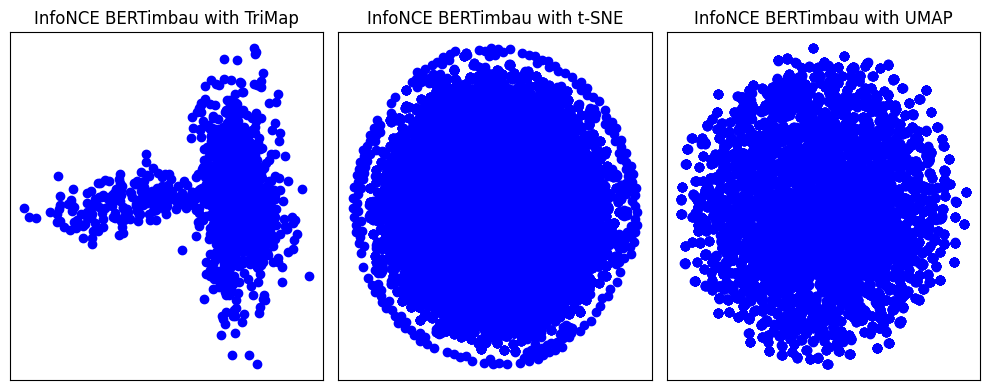

In [31]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting InfoNCE BERTimbau projections
projs = [infonce_bertimbau_trimap, infonce_bertimbau_tsne, infonce_bertimbau_umap]
proj_names = ['InfoNCE BERTimbau with TriMap', 'InfoNCE BERTimbau with t-SNE', \
              'InfoNCE BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [32]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(infonce_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   infonce_bertimbau_attributions, infonce_bertimbau_indices, \
                   save_file='infonce_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(infonce_bertimbau_umap, vanilla_bertimbau_tokens, \
                   infonce_bertimbau_attributions, infonce_bertimbau_indices, \
                   save_file='infonce_bertimbau_umap.csv')

In [33]:
# Cleaning memory
clean_mem([infonce_bertimbau_embeddings, infonce_bertimbau_trimap, infonce_bertimbau_tsne, \
infonce_bertimbau_umap, infonce_bertimbau_attributions, infonce_bertimbau_indices])

## Albertina

### Vanilla Model

In [34]:
# Getting new tokenizer
# tokenizer = AutoTokenizer.from_pretrained('PORTULAN/albertina-1b5-portuguese-ptbr-encoder', \
#                                           use_fast=True)
tokenizer = AutoTokenizer.from_pretrained('PORTULAN/albertina-100m-portuguese-ptbr-encoder', \
                                          use_fast=True)

# Initializing model, turning it into eval mode and zeroing out the gradients
# model = AutoModel.from_pretrained('PORTULAN/albertina-1b5-portuguese-ptbr-encoder')
base_model = AutoModel.from_pretrained('PORTULAN/albertina-100m-portuguese-ptbr-encoder')
base_model = base_model.to(device)
base_model.eval()
base_model.zero_grad()

# Getting sentences' dataset, dataloader and splits
text_ind_df = ind_df[~ind_df['descricao_resumida'].isna()]
max_length = 64
text_dataset = UnsupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 16
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

baseline_input_ids, \
baseline_embedding = get_baseline_embedding(tokenizer.pad_token_id, tokenizer.cls_token_id, \
                                            tokenizer.sep_token_id, max_length, base_model, \
                                            device, fine_tuned=False)

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(base_model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, base_model.embeddings)

In [35]:
# Checking model's STS-B score for reference
_ = stsb_test(base_model, device, tokenizer, max_length=max_length, model_loss='vanilla', \
              verbose=True, train_split=False)

# Checking model's in-context STS-B score for reference too
subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(base_model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='vanilla', verbose=True, train_split=False)

STS-B (Pearson): 0.6905
In-Context STS-B (Pearson): 0.6843


In [36]:
import language_training_utils
importlib.reload(language_training_utils)
from language_training_utils import *

# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_albertina_indices = []
vanilla_albertina_embeddings = []
vanilla_albertina_tokens = []
vanilla_albertina_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    vanilla_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(base_model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_albertina_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1), \
                                                   model_name='albertina')
    vanilla_albertina_tokens.append(tokens)
    vanilla_albertina_attributions.append(attributions)
    
# Concatenating the batches
vanilla_albertina_indices = np.array(vanilla_albertina_indices).squeeze(-1)
vanilla_albertina_embeddings = np.array(torch.cat(vanilla_albertina_embeddings, dim=0))
vanilla_albertina_tokens = np.array(vanilla_albertina_tokens)
vanilla_albertina_attributions = np.array(torch.cat(vanilla_albertina_attributions, dim=0))

100%|█████████████████████| 20964/20964 [1:31:39<00:00,  3.81it/s]


In [37]:
# Getting data projections
vanilla_albertina_trimap, vanilla_albertina_tsne, \
vanilla_albertina_umap = data_projections(vanilla_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_albertina_trimap = normalize(vanilla_albertina_trimap, norm_factor)
vanilla_albertina_tsne = normalize(vanilla_albertina_tsne, norm_factor)
vanilla_albertina_umap = normalize(vanilla_albertina_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

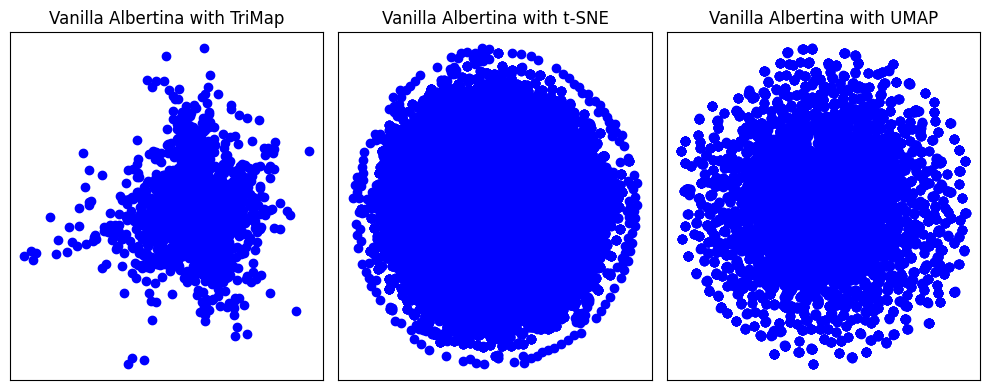

In [38]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting USimCSE BERTimbau projections
projs = [vanilla_albertina_trimap, vanilla_albertina_tsne, vanilla_albertina_umap]
proj_names = ['Vanilla Albertina with TriMap', 'Vanilla Albertina with t-SNE', \
              'Vanilla Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [39]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_albertina_trimap, vanilla_albertina_tokens, \
                   vanilla_albertina_attributions, vanilla_albertina_indices, \
                   save_file='vanilla_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_albertina_umap, vanilla_albertina_tokens, \
                   vanilla_albertina_attributions, vanilla_albertina_indices, \
                   save_file='vanilla_albertina_umap.csv')

In [40]:
# Cleaning memory
clean_mem([vanilla_albertina_embeddings, vanilla_albertina_trimap, vanilla_albertina_tsne, \
vanilla_albertina_umap, vanilla_albertina_attributions, vanilla_albertina_indices])

### Unsupervised SimCSE (Contrastive Learning with no Labels)

----- TEMPERATURA 0.05 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0487 | Val Loss: 0.0025 | STS-B: 0.6605 | In-Context STS-B: 0.8260


Epoch:   8%|█▊                    | 1/12 [05:02<55:28, 302.61s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0045 | Val Loss: 0.0023 | STS-B: 0.6678 | In-Context STS-B: 0.8369


Epoch:  17%|███▋                  | 2/12 [10:05<50:26, 302.68s/it]

New best model found!


Epoch:  25%|█████▌                | 3/12 [15:06<45:17, 301.99s/it]

Epoch 3/12 | Train Loss: 0.0037 | Val Loss: 0.0023 | STS-B: 0.6668 | In-Context STS-B: 0.8302
Epoch 4/12 | Train Loss: 0.0019 | Val Loss: 0.0018 | STS-B: 0.6693 | In-Context STS-B: 0.8397


Epoch:  33%|███████▎              | 4/12 [20:09<40:17, 302.21s/it]

New best model found!
Epoch 5/12 | Train Loss: 0.0030 | Val Loss: 0.0019 | STS-B: 0.6863 | In-Context STS-B: 0.8245


Epoch:  42%|█████████▏            | 5/12 [25:12<35:17, 302.51s/it]

New best model found!
Epoch 6/12 | Train Loss: 0.0026 | Val Loss: 0.0012 | STS-B: 0.6999 | In-Context STS-B: 0.8411


Epoch:  50%|███████████           | 6/12 [30:15<30:16, 302.71s/it]

New best model found!


Epoch:  58%|████████████▊         | 7/12 [35:17<25:12, 302.47s/it]

Epoch 7/12 | Train Loss: 0.0032 | Val Loss: 0.0014 | STS-B: 0.6918 | In-Context STS-B: 0.8385


Epoch:  67%|██████████████▋       | 8/12 [40:18<20:08, 302.01s/it]

Epoch 8/12 | Train Loss: 0.0027 | Val Loss: 0.0012 | STS-B: 0.7048 | In-Context STS-B: 0.8227
Epoch 9/12 | Train Loss: 0.0023 | Val Loss: 0.0012 | STS-B: 0.7118 | In-Context STS-B: 0.8323


Epoch:  75%|████████████████▌     | 9/12 [45:21<15:06, 302.31s/it]

New best model found!
Epoch 10/12 | Train Loss: 0.0026 | Val Loss: 0.0011 | STS-B: 0.7107 | In-Context STS-B: 0.8369


Epoch:  83%|█████████████████▌   | 10/12 [50:24<10:05, 302.54s/it]

New best model found!
Epoch 11/12 | Train Loss: 0.0021 | Val Loss: 0.0011 | STS-B: 0.7132 | In-Context STS-B: 0.8370


Epoch:  92%|███████████████████▎ | 11/12 [55:26<05:02, 302.51s/it]

New best model found!


Epoch: 100%|███████████████████| 12/12 [1:00:28<00:00, 302.35s/it]

Epoch 12/12 | Train Loss: 0.0023 | Val Loss: 0.0012 | STS-B: 0.7051 | In-Context STS-B: 0.8434


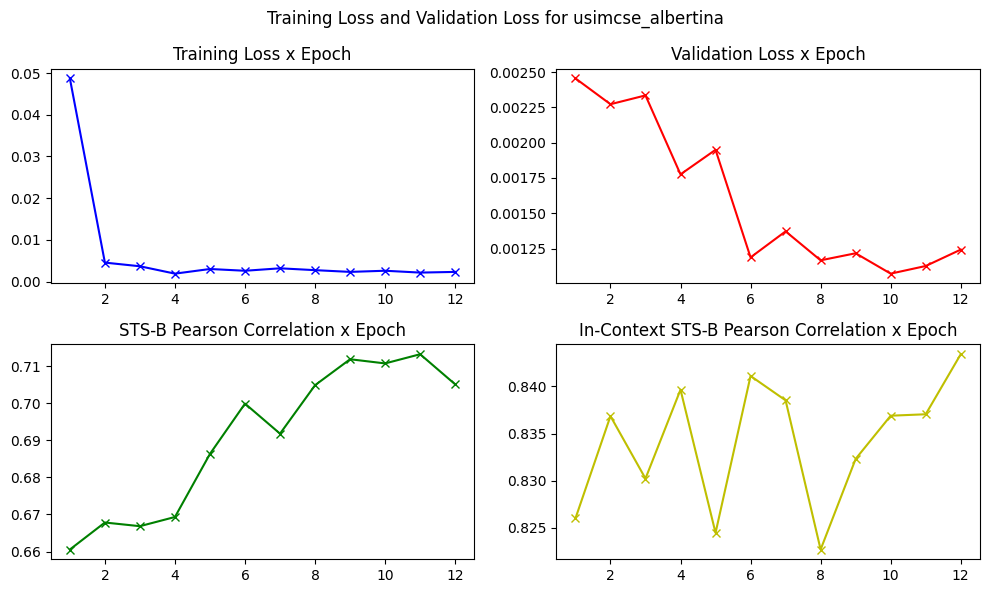

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7013
In-Context STS-B (Pearson): 0.8413
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0512 | Val Loss: 0.0024 | STS-B: 0.6524 | In-Context STS-B: 0.8284


Epoch:   8%|█▊                    | 1/12 [05:05<55:56, 305.14s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0036 | Val Loss: 0.0021 | STS-B: 0.6518 | In-Context STS-B: 0.8308


Epoch:  17%|███▋                  | 2/12 [10:09<50:47, 304.72s/it]

New best model found!
Epoch 3/12 | Train Loss: 0.0027 | Val Loss: 0.0021 | STS-B: 0.6620 | In-Context STS-B: 0.8323


Epoch:  25%|█████▌                | 3/12 [15:13<45:40, 304.45s/it]

New best model found!
Epoch 4/12 | Train Loss: 0.0031 | Val Loss: 0.0016 | STS-B: 0.6870 | In-Context STS-B: 0.8411


Epoch:  33%|███████▎              | 4/12 [20:18<40:36, 304.52s/it]

New best model found!
Epoch 5/12 | Train Loss: 0.0033 | Val Loss: 0.0016 | STS-B: 0.6925 | In-Context STS-B: 0.8373


Epoch:  42%|█████████▏            | 5/12 [25:22<35:31, 304.50s/it]

New best model found!
Epoch 6/12 | Train Loss: 0.0026 | Val Loss: 0.0015 | STS-B: 0.6936 | In-Context STS-B: 0.8402


Epoch:  50%|███████████           | 6/12 [30:28<30:28, 304.77s/it]

New best model found!
Epoch 7/12 | Train Loss: 0.0024 | Val Loss: 0.0018 | STS-B: 0.7042 | In-Context STS-B: 0.8364


Epoch:  58%|████████████▊         | 7/12 [35:33<25:24, 304.86s/it]

New best model found!


Epoch:  67%|██████████████▋       | 8/12 [40:36<20:17, 304.41s/it]

Epoch 8/12 | Train Loss: 0.0016 | Val Loss: 0.0015 | STS-B: 0.7097 | In-Context STS-B: 0.8255
Epoch 9/12 | Train Loss: 0.0020 | Val Loss: 0.0013 | STS-B: 0.7243 | In-Context STS-B: 0.8195


Epoch:  75%|████████████████▌     | 9/12 [45:41<15:14, 304.70s/it]

New best model found!
Epoch 10/12 | Train Loss: 0.0016 | Val Loss: 0.0012 | STS-B: 0.7149 | In-Context STS-B: 0.8451


Epoch:  83%|█████████████████▌   | 10/12 [50:46<10:09, 304.58s/it]

New best model found!


Epoch:  92%|███████████████████▎ | 11/12 [55:48<05:03, 303.92s/it]

Epoch 11/12 | Train Loss: 0.0023 | Val Loss: 0.0013 | STS-B: 0.7048 | In-Context STS-B: 0.8192


Epoch: 100%|███████████████████| 12/12 [1:00:52<00:00, 304.37s/it]

Epoch 12/12 | Train Loss: 0.0026 | Val Loss: 0.0008 | STS-B: 0.7136 | In-Context STS-B: 0.8312


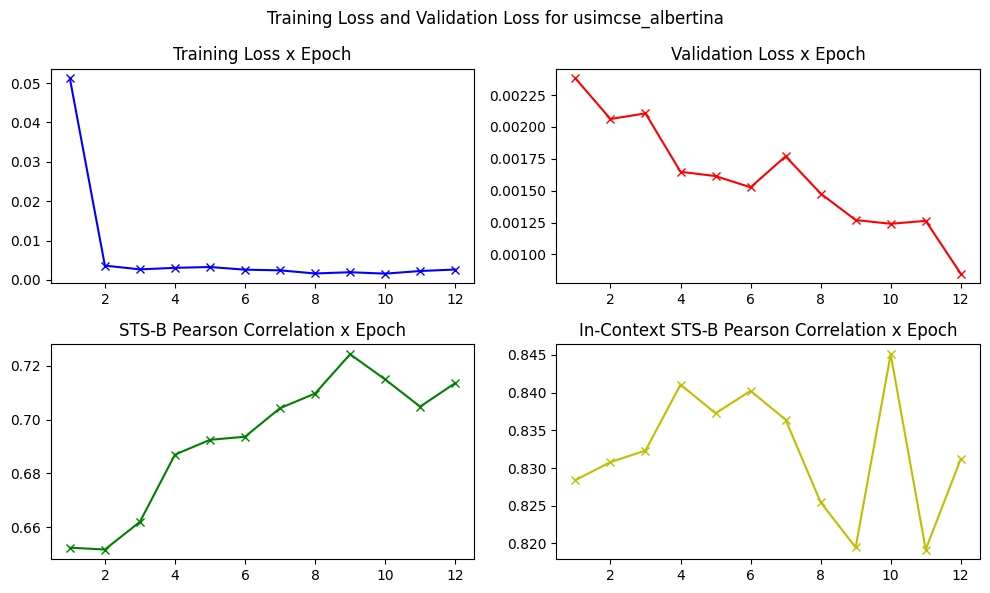

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.6984
In-Context STS-B (Pearson): 0.8555
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0507 | Val Loss: 0.0025 | STS-B: 0.6557 | In-Context STS-B: 0.8215


Epoch:   8%|█▊                    | 1/12 [05:04<55:46, 304.23s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0034 | Val Loss: 0.0023 | STS-B: 0.6718 | In-Context STS-B: 0.8329


Epoch:  17%|███▋                  | 2/12 [10:07<50:37, 303.79s/it]

New best model found!
Epoch 3/12 | Train Loss: 0.0040 | Val Loss: 0.0019 | STS-B: 0.6863 | In-Context STS-B: 0.8374


Epoch:  25%|█████▌                | 3/12 [15:12<45:36, 304.06s/it]

New best model found!


Epoch:  33%|███████▎              | 4/12 [20:14<40:26, 303.26s/it]

Epoch 4/12 | Train Loss: 0.0022 | Val Loss: 0.0018 | STS-B: 0.6860 | In-Context STS-B: 0.8332
Epoch 5/12 | Train Loss: 0.0024 | Val Loss: 0.0015 | STS-B: 0.6954 | In-Context STS-B: 0.8412


Epoch:  42%|█████████▏            | 5/12 [25:18<35:26, 303.75s/it]

New best model found!


Epoch:  50%|███████████           | 6/12 [30:21<30:21, 303.55s/it]

Epoch 6/12 | Train Loss: 0.0040 | Val Loss: 0.0018 | STS-B: 0.7001 | In-Context STS-B: 0.8230
Epoch 7/12 | Train Loss: 0.0022 | Val Loss: 0.0014 | STS-B: 0.7107 | In-Context STS-B: 0.8325


Epoch:  58%|████████████▊         | 7/12 [35:26<25:19, 303.95s/it]

New best model found!
Epoch 8/12 | Train Loss: 0.0021 | Val Loss: 0.0012 | STS-B: 0.7250 | In-Context STS-B: 0.8299


Epoch:  67%|██████████████▋       | 8/12 [40:31<20:17, 304.30s/it]

New best model found!


Epoch:  75%|████████████████▌     | 9/12 [45:34<15:11, 303.77s/it]

Epoch 9/12 | Train Loss: 0.0025 | Val Loss: 0.0013 | STS-B: 0.7203 | In-Context STS-B: 0.8291


Epoch:  83%|█████████████████▌   | 10/12 [50:36<10:06, 303.18s/it]

Epoch 10/12 | Train Loss: 0.0020 | Val Loss: 0.0011 | STS-B: 0.7125 | In-Context STS-B: 0.8177


Epoch:  92%|███████████████████▎ | 11/12 [55:39<05:03, 303.11s/it]

Epoch 11/12 | Train Loss: 0.0028 | Val Loss: 0.0009 | STS-B: 0.7134 | In-Context STS-B: 0.8350


Epoch: 100%|███████████████████| 12/12 [1:00:41<00:00, 303.43s/it]

Epoch 12/12 | Train Loss: 0.0020 | Val Loss: 0.0011 | STS-B: 0.7052 | In-Context STS-B: 0.8155


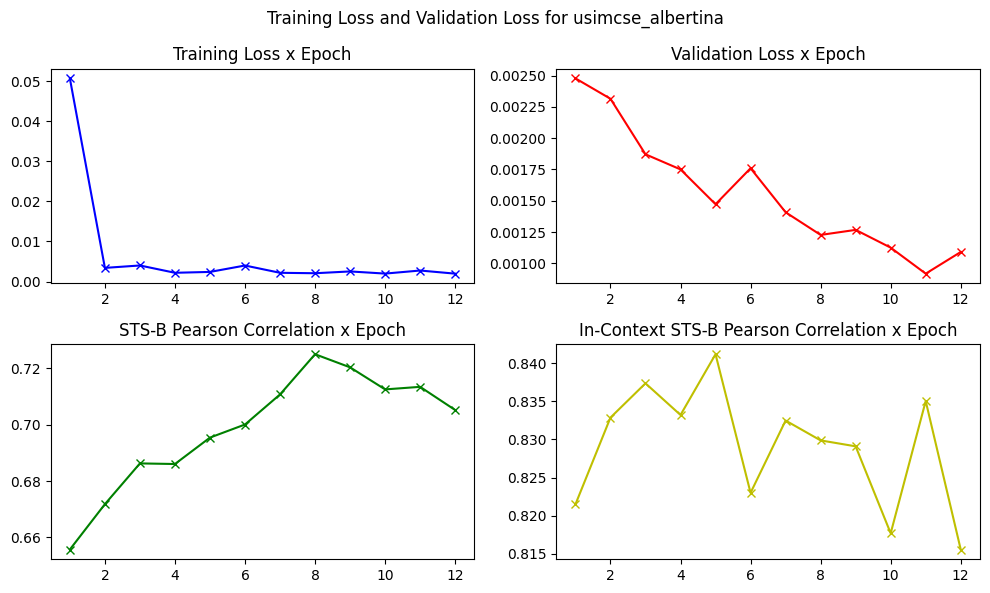

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7066
In-Context STS-B (Pearson): 0.8372
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.1403 | Val Loss: 0.0172 | STS-B: 0.6990 | In-Context STS-B: 0.8388


Epoch:   8%|█▊                    | 1/12 [05:04<55:47, 304.34s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0353 | Val Loss: 0.0139 | STS-B: 0.7176 | In-Context STS-B: 0.8495


Epoch:  17%|███▋                  | 2/12 [10:08<50:41, 304.17s/it]

New best model found!
Epoch 3/12 | Train Loss: 0.0259 | Val Loss: 0.0128 | STS-B: 0.7216 | In-Context STS-B: 0.8533


Epoch:  25%|█████▌                | 3/12 [15:11<45:34, 303.81s/it]

New best model found!


Epoch:  33%|███████▎              | 4/12 [20:13<40:24, 303.05s/it]

Epoch 4/12 | Train Loss: 0.0225 | Val Loss: 0.0126 | STS-B: 0.7212 | In-Context STS-B: 0.8506


Epoch:  42%|█████████▏            | 5/12 [25:16<35:20, 302.98s/it]

Epoch 5/12 | Train Loss: 0.0199 | Val Loss: 0.0116 | STS-B: 0.7238 | In-Context STS-B: 0.8493


Epoch:  50%|███████████           | 6/12 [30:22<30:23, 303.87s/it]

Epoch 6/12 | Train Loss: 0.0179 | Val Loss: 0.0115 | STS-B: 0.7222 | In-Context STS-B: 0.8474
Epoch 7/12 | Train Loss: 0.0173 | Val Loss: 0.0107 | STS-B: 0.7293 | In-Context STS-B: 0.8539


Epoch:  58%|████████████▊         | 7/12 [35:28<25:22, 304.55s/it]

New best model found!


Epoch:  67%|██████████████▋       | 8/12 [40:29<20:14, 303.53s/it]

Epoch 8/12 | Train Loss: 0.0160 | Val Loss: 0.0105 | STS-B: 0.7244 | In-Context STS-B: 0.8507


Epoch:  75%|████████████████▌     | 9/12 [45:31<15:09, 303.19s/it]

Epoch 9/12 | Train Loss: 0.0157 | Val Loss: 0.0100 | STS-B: 0.7266 | In-Context STS-B: 0.8488


Epoch:  83%|█████████████████▌   | 10/12 [50:33<10:05, 302.73s/it]

Epoch 10/12 | Train Loss: 0.0147 | Val Loss: 0.0097 | STS-B: 0.7204 | In-Context STS-B: 0.8456


Epoch:  92%|███████████████████▎ | 11/12 [55:36<05:02, 302.71s/it]

Epoch 11/12 | Train Loss: 0.0141 | Val Loss: 0.0101 | STS-B: 0.7193 | In-Context STS-B: 0.8486


Epoch: 100%|███████████████████| 12/12 [1:00:37<00:00, 303.16s/it]

Epoch 12/12 | Train Loss: 0.0141 | Val Loss: 0.0099 | STS-B: 0.7121 | In-Context STS-B: 0.8466


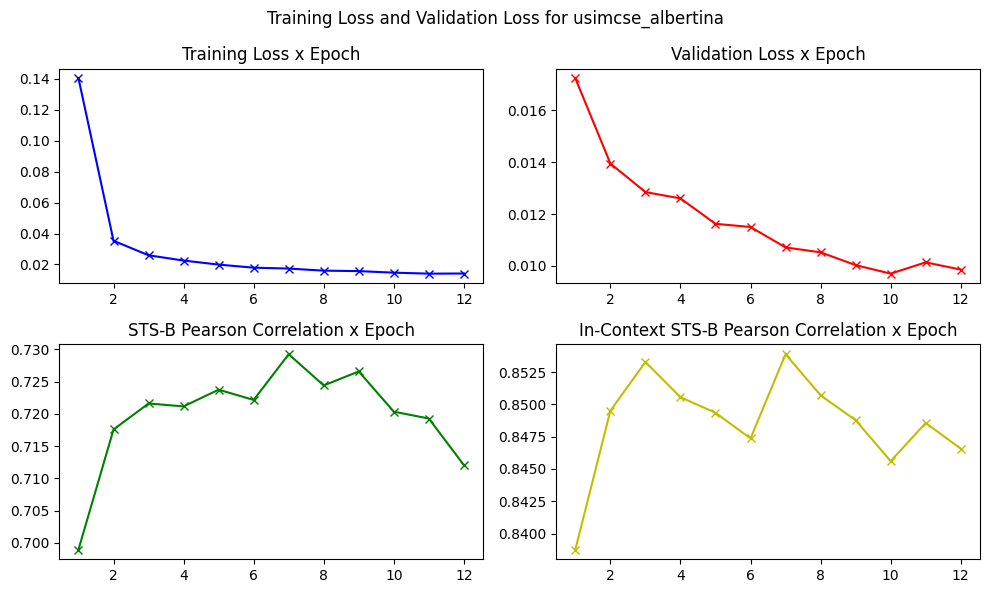

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7104
In-Context STS-B (Pearson): 0.8625
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.1411 | Val Loss: 0.0163 | STS-B: 0.7023 | In-Context STS-B: 0.8400


Epoch:   8%|█▊                    | 1/12 [05:02<55:26, 302.45s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0343 | Val Loss: 0.0141 | STS-B: 0.7188 | In-Context STS-B: 0.8480


Epoch:  17%|███▋                  | 2/12 [10:06<50:34, 303.49s/it]

New best model found!
Epoch 3/12 | Train Loss: 0.0261 | Val Loss: 0.0129 | STS-B: 0.7220 | In-Context STS-B: 0.8488


Epoch:  25%|█████▌                | 3/12 [15:10<45:32, 303.62s/it]

New best model found!


Epoch:  33%|███████▎              | 4/12 [20:11<40:19, 302.48s/it]

Epoch 4/12 | Train Loss: 0.0215 | Val Loss: 0.0127 | STS-B: 0.7215 | In-Context STS-B: 0.8462
Epoch 5/12 | Train Loss: 0.0207 | Val Loss: 0.0120 | STS-B: 0.7260 | In-Context STS-B: 0.8454


Epoch:  42%|█████████▏            | 5/12 [25:14<35:19, 302.85s/it]

New best model found!
Epoch 6/12 | Train Loss: 0.0188 | Val Loss: 0.0114 | STS-B: 0.7268 | In-Context STS-B: 0.8474


Epoch:  50%|███████████           | 6/12 [30:19<30:20, 303.39s/it]

New best model found!
Epoch 7/12 | Train Loss: 0.0169 | Val Loss: 0.0116 | STS-B: 0.7250 | In-Context STS-B: 0.8505


Epoch:  58%|████████████▊         | 7/12 [35:22<25:17, 303.43s/it]

New best model found!
Epoch 8/12 | Train Loss: 0.0165 | Val Loss: 0.0111 | STS-B: 0.7294 | In-Context STS-B: 0.8549


Epoch:  67%|██████████████▋       | 8/12 [40:25<20:13, 303.32s/it]

New best model found!


Epoch:  75%|████████████████▌     | 9/12 [45:28<15:09, 303.23s/it]

Epoch 9/12 | Train Loss: 0.0152 | Val Loss: 0.0109 | STS-B: 0.7270 | In-Context STS-B: 0.8532


Epoch:  83%|█████████████████▌   | 10/12 [50:30<10:05, 302.86s/it]

Epoch 10/12 | Train Loss: 0.0144 | Val Loss: 0.0104 | STS-B: 0.7151 | In-Context STS-B: 0.8518


Epoch:  92%|███████████████████▎ | 11/12 [55:33<05:02, 302.67s/it]

Epoch 11/12 | Train Loss: 0.0141 | Val Loss: 0.0098 | STS-B: 0.7133 | In-Context STS-B: 0.8537


Epoch: 100%|███████████████████| 12/12 [1:00:35<00:00, 302.95s/it]

Epoch 12/12 | Train Loss: 0.0141 | Val Loss: 0.0097 | STS-B: 0.7068 | In-Context STS-B: 0.8535


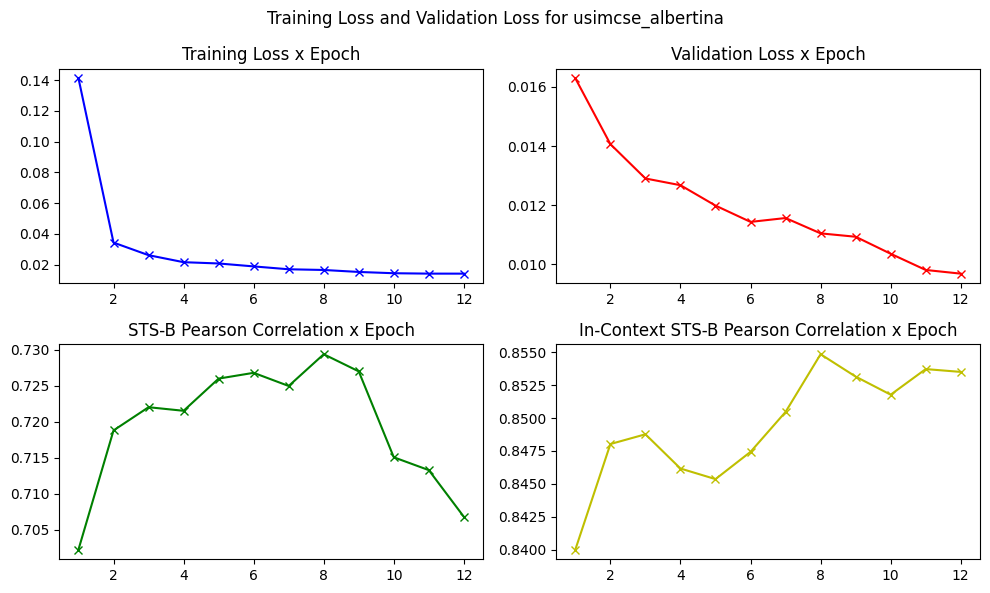

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7164
In-Context STS-B (Pearson): 0.8602
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.1410 | Val Loss: 0.0164 | STS-B: 0.7031 | In-Context STS-B: 0.8427


Epoch:   8%|█▊                    | 1/12 [05:03<55:40, 303.72s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0337 | Val Loss: 0.0137 | STS-B: 0.7183 | In-Context STS-B: 0.8515


Epoch:  17%|███▋                  | 2/12 [10:07<50:37, 303.73s/it]

New best model found!
Epoch 3/12 | Train Loss: 0.0252 | Val Loss: 0.0127 | STS-B: 0.7245 | In-Context STS-B: 0.8526


Epoch:  25%|█████▌                | 3/12 [15:10<45:30, 303.42s/it]

New best model found!


Epoch:  33%|███████▎              | 4/12 [20:12<40:23, 302.93s/it]

Epoch 4/12 | Train Loss: 0.0230 | Val Loss: 0.0122 | STS-B: 0.7241 | In-Context STS-B: 0.8493
Epoch 5/12 | Train Loss: 0.0211 | Val Loss: 0.0118 | STS-B: 0.7282 | In-Context STS-B: 0.8551


Epoch:  42%|█████████▏            | 5/12 [25:16<35:23, 303.33s/it]

New best model found!


Epoch:  50%|███████████           | 6/12 [30:17<30:15, 302.53s/it]

Epoch 6/12 | Train Loss: 0.0178 | Val Loss: 0.0116 | STS-B: 0.7246 | In-Context STS-B: 0.8506
Epoch 7/12 | Train Loss: 0.0169 | Val Loss: 0.0111 | STS-B: 0.7313 | In-Context STS-B: 0.8559


Epoch:  58%|████████████▊         | 7/12 [35:22<25:15, 303.14s/it]

New best model found!


Epoch:  67%|██████████████▋       | 8/12 [40:23<20:10, 302.52s/it]

Epoch 8/12 | Train Loss: 0.0164 | Val Loss: 0.0104 | STS-B: 0.7259 | In-Context STS-B: 0.8530


Epoch:  75%|████████████████▌     | 9/12 [45:25<15:06, 302.30s/it]

Epoch 9/12 | Train Loss: 0.0152 | Val Loss: 0.0102 | STS-B: 0.7265 | In-Context STS-B: 0.8501


Epoch:  83%|█████████████████▌   | 10/12 [50:27<10:04, 302.22s/it]

Epoch 10/12 | Train Loss: 0.0141 | Val Loss: 0.0101 | STS-B: 0.7254 | In-Context STS-B: 0.8524
Epoch 11/12 | Train Loss: 0.0147 | Val Loss: 0.0100 | STS-B: 0.7312 | In-Context STS-B: 0.8576


Epoch:  92%|███████████████████▎ | 11/12 [55:31<05:02, 302.82s/it]

New best model found!


Epoch: 100%|███████████████████| 12/12 [1:00:33<00:00, 302.78s/it]

Epoch 12/12 | Train Loss: 0.0146 | Val Loss: 0.0097 | STS-B: 0.7317 | In-Context STS-B: 0.8548


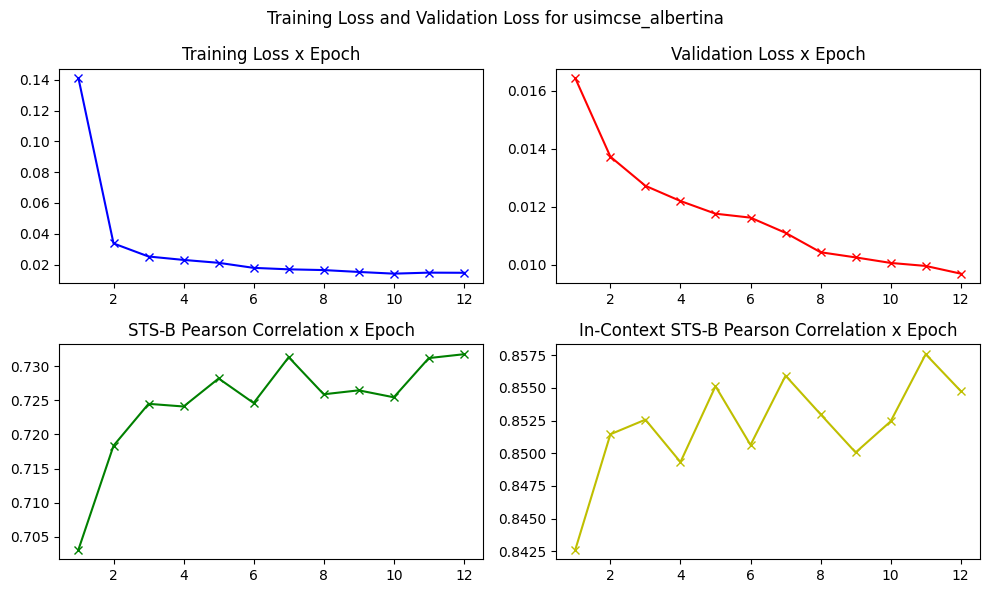

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7157
In-Context STS-B (Pearson): 0.8632
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.7144 | Val Loss: 0.3948 | STS-B: 0.7037 | In-Context STS-B: 0.8128


Epoch:   8%|█▊                    | 1/12 [05:03<55:39, 303.62s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.4958 | Val Loss: 0.3723 | STS-B: 0.7038 | In-Context STS-B: 0.8139


Epoch:  17%|███▋                  | 2/12 [10:07<50:36, 303.66s/it]

New best model found!


Epoch:  25%|█████▌                | 3/12 [15:09<45:27, 303.08s/it]

Epoch 3/12 | Train Loss: 0.4546 | Val Loss: 0.3603 | STS-B: 0.6963 | In-Context STS-B: 0.8044


Epoch:  33%|███████▎              | 4/12 [20:10<40:17, 302.24s/it]

Epoch 4/12 | Train Loss: 0.4268 | Val Loss: 0.3547 | STS-B: 0.6940 | In-Context STS-B: 0.8064


Epoch:  42%|█████████▏            | 5/12 [25:11<35:12, 301.75s/it]

Epoch 5/12 | Train Loss: 0.4142 | Val Loss: 0.3496 | STS-B: 0.6747 | In-Context STS-B: 0.7974


Epoch:  42%|█████████▏            | 5/12 [30:12<42:18, 362.58s/it]

Epoch 6/12 | Train Loss: 0.4016 | Val Loss: 0.3429 | STS-B: 0.6650 | In-Context STS-B: 0.7922
Early stopping!


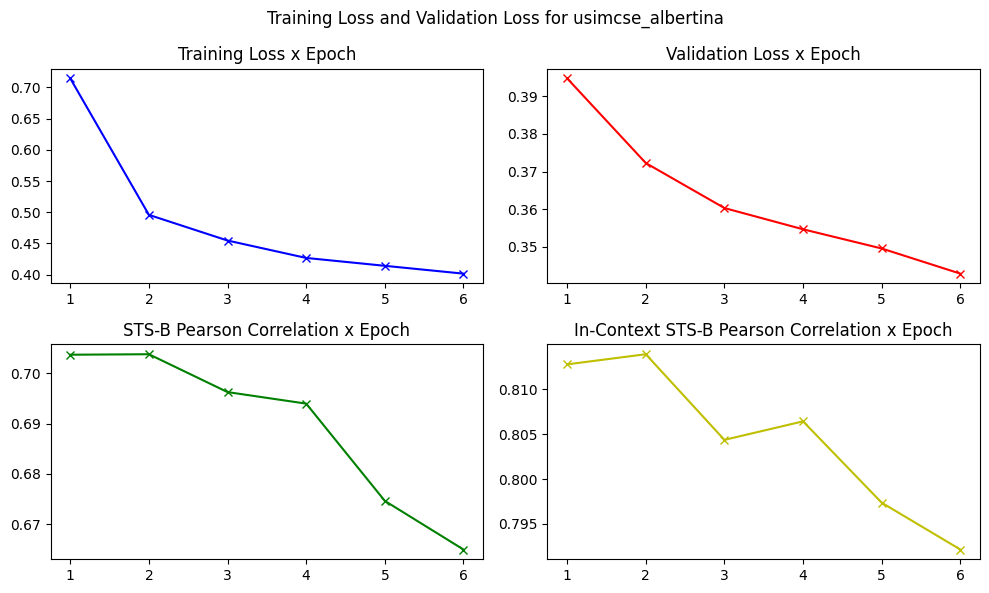

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.6911
In-Context STS-B (Pearson): 0.8266
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.7153 | Val Loss: 0.3920 | STS-B: 0.6998 | In-Context STS-B: 0.8124


Epoch:   8%|█▊                    | 1/12 [05:02<55:28, 302.61s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.4981 | Val Loss: 0.3759 | STS-B: 0.7053 | In-Context STS-B: 0.8147


Epoch:  17%|███▋                  | 2/12 [10:07<50:38, 303.86s/it]

New best model found!


Epoch:  25%|█████▌                | 3/12 [15:09<45:26, 302.99s/it]

Epoch 3/12 | Train Loss: 0.4546 | Val Loss: 0.3636 | STS-B: 0.7027 | In-Context STS-B: 0.8142


Epoch:  33%|███████▎              | 4/12 [20:10<40:18, 302.26s/it]

Epoch 4/12 | Train Loss: 0.4297 | Val Loss: 0.3485 | STS-B: 0.6961 | In-Context STS-B: 0.8051


Epoch:  42%|█████████▏            | 5/12 [25:11<35:13, 301.97s/it]

Epoch 5/12 | Train Loss: 0.4142 | Val Loss: 0.3465 | STS-B: 0.6873 | In-Context STS-B: 0.7936


Epoch:  42%|█████████▏            | 5/12 [30:12<42:17, 362.51s/it]

Epoch 6/12 | Train Loss: 0.4003 | Val Loss: 0.3413 | STS-B: 0.6725 | In-Context STS-B: 0.7842
Early stopping!


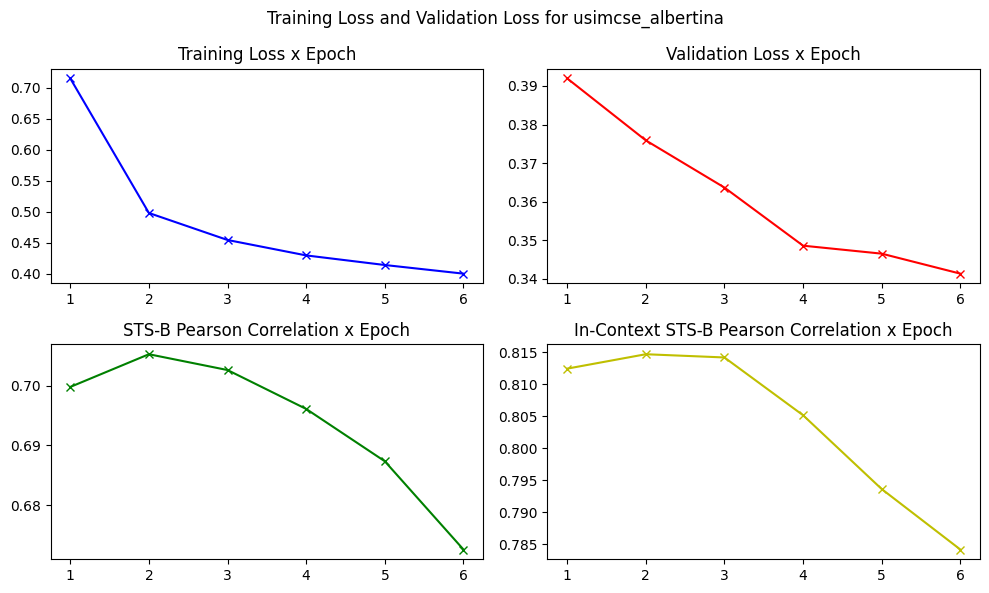

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.6873
In-Context STS-B (Pearson): 0.8285
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6838


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.7143 | Val Loss: 0.3917 | STS-B: 0.7037 | In-Context STS-B: 0.8120


Epoch:   8%|█▊                    | 1/12 [05:03<55:43, 303.98s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.4968 | Val Loss: 0.3728 | STS-B: 0.7030 | In-Context STS-B: 0.8142


Epoch:  17%|███▋                  | 2/12 [10:08<50:40, 304.05s/it]

New best model found!


Epoch:  25%|█████▌                | 3/12 [15:09<45:24, 302.71s/it]

Epoch 3/12 | Train Loss: 0.4543 | Val Loss: 0.3608 | STS-B: 0.7018 | In-Context STS-B: 0.8135


Epoch:  33%|███████▎              | 4/12 [20:09<40:14, 301.79s/it]

Epoch 4/12 | Train Loss: 0.4312 | Val Loss: 0.3519 | STS-B: 0.6969 | In-Context STS-B: 0.8104


Epoch:  42%|█████████▏            | 5/12 [25:10<35:11, 301.59s/it]

Epoch 5/12 | Train Loss: 0.4142 | Val Loss: 0.3470 | STS-B: 0.6794 | In-Context STS-B: 0.7981


Epoch:  42%|█████████▏            | 5/12 [30:11<42:16, 362.36s/it]

Epoch 6/12 | Train Loss: 0.4007 | Val Loss: 0.3441 | STS-B: 0.6557 | In-Context STS-B: 0.7830
Early stopping!


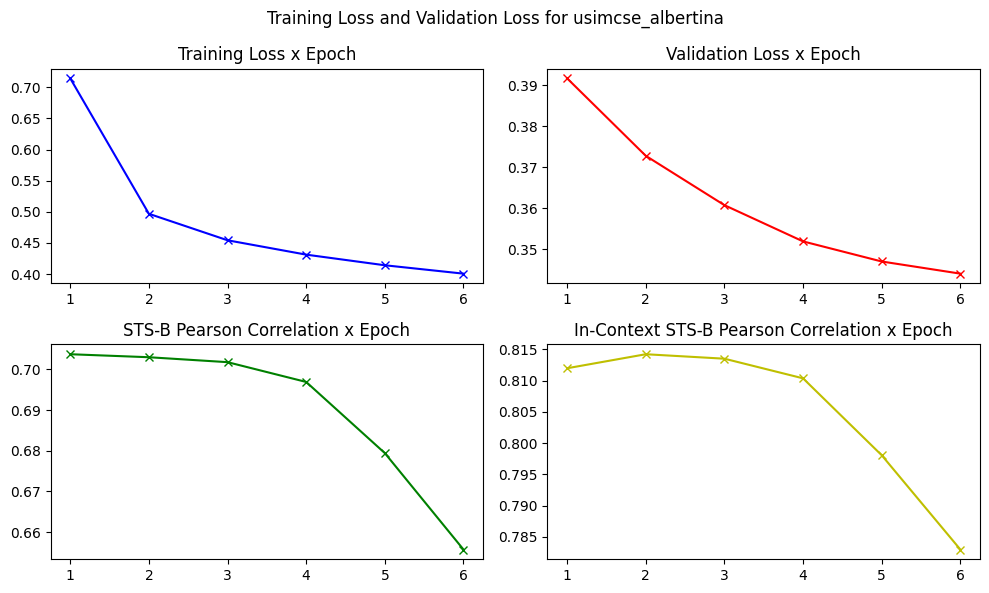

/tmp/ipykernel_1397029/125602510.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.6903
In-Context STS-B (Pearson): 0.8287


In [41]:
# Testing multiple times with multiple temperatures to better evaluate model's performance
# temperatures = [0.05 for i in range(3)] + [0.1 for i in range(3)] + [0.2 for i in range(3)]

# for temp in temperatures:
#     print(f'----- TEMPERATURA {temp} -----')

# Restarting baseline model so not to get the already fine-tuned from previous method or run
base_model = AutoModel.from_pretrained('PORTULAN/albertina-100m-portuguese-ptbr-encoder')

# Initializing USimCSE model and auxiliar variables
dropout_prob = 0.1
model = USimCSEModel(base_model, tokenizer.pad_token_id, device, dropout_prob)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
epochs = 16
temperature = 0.1
patience = max(2, math.ceil(epochs*0.1))
model_name = 'usimcse_albertina'
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
usimcse_indices, usimcse_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = usimcse_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='usimcse', \
              verbose=True, train_split=False)
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='usimcse', verbose=True, train_split=False)

In [42]:
# Recomputing baseline embedding for fine-tuned model
baseline_input_ids, \
baseline_embedding = get_baseline_embedding(tokenizer.pad_token_id, tokenizer.cls_token_id, \
                                            tokenizer.sep_token_id, max_length, model, \
                                            device, fine_tuned=True)

# Instanciating attribution computation class for fine-tuned model
usimcse_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
usimcse_wrapped_model.eval()
lig = LayerIntegratedGradients(usimcse_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
usimcse_albertina_indices = []
usimcse_albertina_embeddings = []
usimcse_albertina_attributions = []
for indices, input_ids in tqdm(text_dataloader):
    # Saving indices
    usimcse_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    usimcse_albertina_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, \
                                                          full_batch_size-1), \
                                           model_name='albertina')
    usimcse_albertina_attributions.append(attributions)

# Concatenating the batches
usimcse_albertina_indices = np.array(usimcse_albertina_indices).squeeze(-1)
usimcse_albertina_embeddings = np.array(torch.cat(usimcse_albertina_embeddings, dim=0))
usimcse_albertina_attributions = np.array(torch.cat(usimcse_albertina_attributions, dim=0))

100%|█████████████████████| 20964/20964 [1:33:03<00:00,  3.75it/s]


In [43]:
# Getting data projections
usimcse_albertina_trimap, usimcse_albertina_tsne, \
usimcse_albertina_umap = data_projections(usimcse_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
usimcse_albertina_trimap = normalize(usimcse_albertina_trimap, norm_factor)
usimcse_albertina_tsne = normalize(usimcse_albertina_tsne, norm_factor)
usimcse_albertina_umap = normalize(usimcse_albertina_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


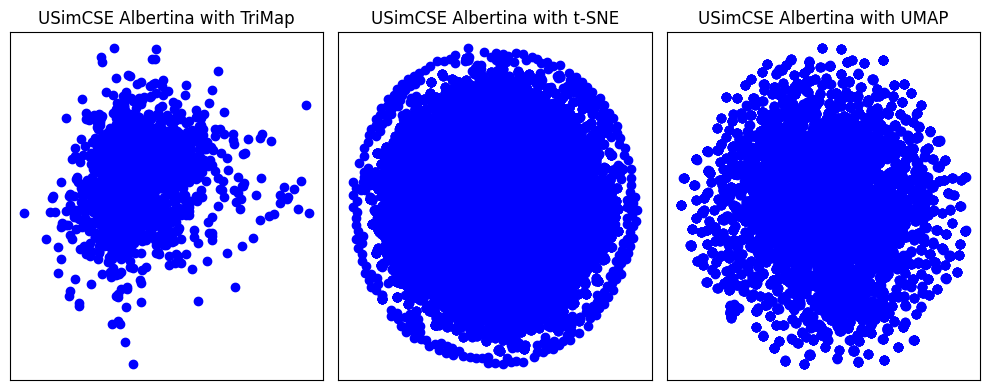

In [44]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting USimCSE Albertina projections
projs = [usimcse_albertina_trimap, usimcse_albertina_tsne, usimcse_albertina_umap]
proj_names = ['USimCSE Albertina with TriMap', 'USimCSE Albertina with t-SNE', \
              'USimCSE Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [45]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(usimcse_albertina_trimap, vanilla_albertina_tokens, \
                   usimcse_albertina_attributions, usimcse_albertina_indices, \
                   save_file='usimcse_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(usimcse_albertina_umap, vanilla_albertina_tokens, \
                   usimcse_albertina_attributions, usimcse_albertina_indices, \
                   save_file='usimcse_albertina_umap.csv')

In [46]:
# Cleaning memory
clean_mem([usimcse_albertina_embeddings, usimcse_albertina_trimap, usimcse_albertina_tsne, \
usimcse_albertina_umap, usimcse_albertina_attributions, usimcse_albertina_indices])

###  Supervised InfoNCE (Contrastive Learning with Labels)

----- TEMPERATURA 0.05 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6755


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0427 | Val Loss: 0.0201 | STS-B: 0.7267 | In-Context STS-B: 0.8456


Epoch:   8%|█▌                 | 1/12 [28:00<5:08:06, 1680.57s/it]

New best model found!


Epoch:  17%|███▏               | 2/12 [55:56<4:39:39, 1678.00s/it]

Epoch 2/12 | Train Loss: 0.0066 | Val Loss: 0.0084 | STS-B: 0.7118 | In-Context STS-B: 0.8496
Epoch 3/12 | Train Loss: 0.0020 | Val Loss: 0.0098 | STS-B: 0.7560 | In-Context STS-B: 0.8538


Epoch:  25%|████▎            | 3/12 [1:23:58<4:11:58, 1679.86s/it]

New best model found!


Epoch:  33%|█████▋           | 4/12 [1:51:59<3:44:02, 1680.30s/it]

Epoch 4/12 | Train Loss: 0.0011 | Val Loss: 0.0154 | STS-B: 0.7384 | In-Context STS-B: 0.8569


Epoch:  42%|███████          | 5/12 [2:20:02<3:16:07, 1681.08s/it]

Epoch 5/12 | Train Loss: 0.0007 | Val Loss: 0.0076 | STS-B: 0.7476 | In-Context STS-B: 0.8584


Epoch:  50%|████████▌        | 6/12 [2:48:07<2:48:14, 1682.41s/it]

Epoch 6/12 | Train Loss: 0.0007 | Val Loss: 0.0079 | STS-B: 0.7462 | In-Context STS-B: 0.8556


Epoch:  58%|█████████▉       | 7/12 [3:16:10<2:20:13, 1682.70s/it]

Epoch 7/12 | Train Loss: 0.0002 | Val Loss: 0.0077 | STS-B: 0.7212 | In-Context STS-B: 0.8603
Epoch 8/12 | Train Loss: 0.0002 | Val Loss: 0.0080 | STS-B: 0.7565 | In-Context STS-B: 0.8695


Epoch:  67%|███████████▎     | 8/12 [3:44:17<1:52:16, 1684.09s/it]

New best model found!


Epoch:  75%|████████████▊    | 9/12 [4:12:21<1:24:12, 1684.14s/it]

Epoch 9/12 | Train Loss: 0.0001 | Val Loss: 0.0088 | STS-B: 0.7607 | In-Context STS-B: 0.8589


Epoch:  83%|███████████████   | 10/12 [4:40:25<56:08, 1684.08s/it]

Epoch 10/12 | Train Loss: 0.0001 | Val Loss: 0.0081 | STS-B: 0.7542 | In-Context STS-B: 0.8592


Epoch:  92%|████████████████▌ | 11/12 [5:08:27<28:03, 1683.34s/it]

Epoch 11/12 | Train Loss: 0.0000 | Val Loss: 0.0074 | STS-B: 0.7529 | In-Context STS-B: 0.8616


Epoch: 100%|██████████████████| 12/12 [5:36:29<00:00, 1682.48s/it]

Epoch 12/12 | Train Loss: 0.0001 | Val Loss: 0.0077 | STS-B: 0.7379 | In-Context STS-B: 0.8599


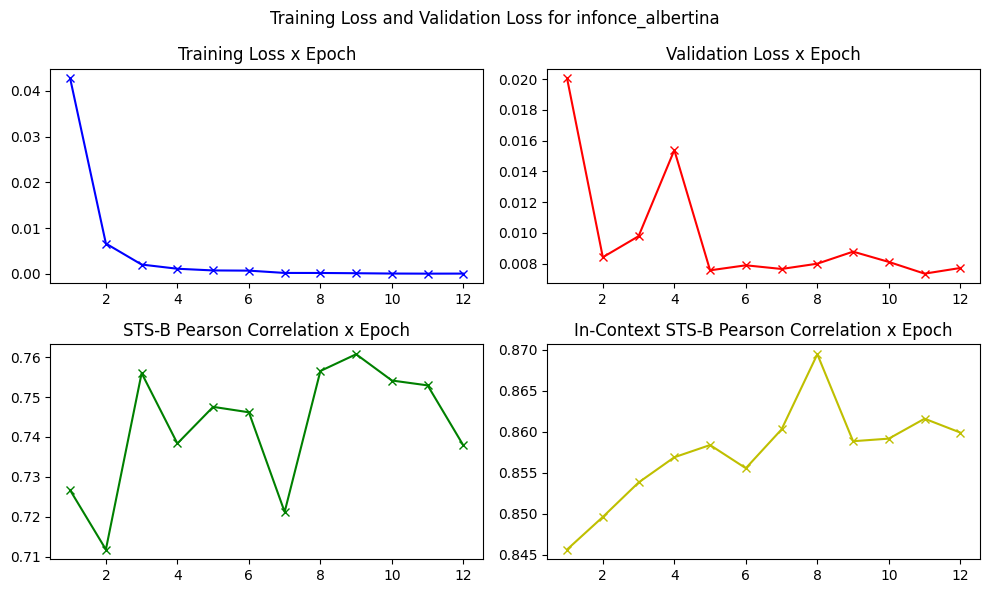

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7380
In-Context STS-B (Pearson): 0.8609
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6791


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0437 | Val Loss: 0.0189 | STS-B: 0.7347 | In-Context STS-B: 0.8388


Epoch:   8%|█▌                 | 1/12 [28:03<5:08:40, 1683.68s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0059 | Val Loss: 0.0119 | STS-B: 0.7428 | In-Context STS-B: 0.8377


Epoch:  17%|███▏               | 2/12 [56:07<4:40:37, 1683.73s/it]

New best model found!
Epoch 3/12 | Train Loss: 0.0028 | Val Loss: 0.0092 | STS-B: 0.7408 | In-Context STS-B: 0.8495


Epoch:  25%|████▎            | 3/12 [1:24:11<4:12:36, 1684.01s/it]

New best model found!
Epoch 4/12 | Train Loss: 0.0016 | Val Loss: 0.0126 | STS-B: 0.7576 | In-Context STS-B: 0.8397


Epoch:  33%|█████▋           | 4/12 [1:52:16<3:44:34, 1684.33s/it]

New best model found!
Epoch 5/12 | Train Loss: 0.0009 | Val Loss: 0.0095 | STS-B: 0.7543 | In-Context STS-B: 0.8514


Epoch:  42%|███████          | 5/12 [2:20:20<3:16:28, 1684.14s/it]

New best model found!


Epoch:  50%|████████▌        | 6/12 [2:48:22<2:48:20, 1683.40s/it]

Epoch 6/12 | Train Loss: 0.0004 | Val Loss: 0.0092 | STS-B: 0.7464 | In-Context STS-B: 0.8546


Epoch:  58%|█████████▉       | 7/12 [3:16:25<2:20:16, 1683.23s/it]

Epoch 7/12 | Train Loss: 0.0003 | Val Loss: 0.0106 | STS-B: 0.7492 | In-Context STS-B: 0.8533


Epoch:  67%|███████████▎     | 8/12 [3:44:28<1:52:13, 1683.25s/it]

Epoch 8/12 | Train Loss: 0.0002 | Val Loss: 0.0109 | STS-B: 0.7428 | In-Context STS-B: 0.8542


Epoch:  75%|████████████▊    | 9/12 [4:12:31<1:24:09, 1683.10s/it]

Epoch 9/12 | Train Loss: 0.0002 | Val Loss: 0.0123 | STS-B: 0.7453 | In-Context STS-B: 0.8428


Epoch:  83%|███████████████   | 10/12 [4:40:34<56:06, 1683.11s/it]

Epoch 10/12 | Train Loss: 0.0001 | Val Loss: 0.0113 | STS-B: 0.7358 | In-Context STS-B: 0.8457


Epoch:  92%|████████████████▌ | 11/12 [5:08:37<28:03, 1683.04s/it]

Epoch 11/12 | Train Loss: 0.0001 | Val Loss: 0.0092 | STS-B: 0.7415 | In-Context STS-B: 0.8454


Epoch: 100%|██████████████████| 12/12 [5:36:38<00:00, 1683.23s/it]

Epoch 12/12 | Train Loss: 0.0001 | Val Loss: 0.0078 | STS-B: 0.7490 | In-Context STS-B: 0.8489


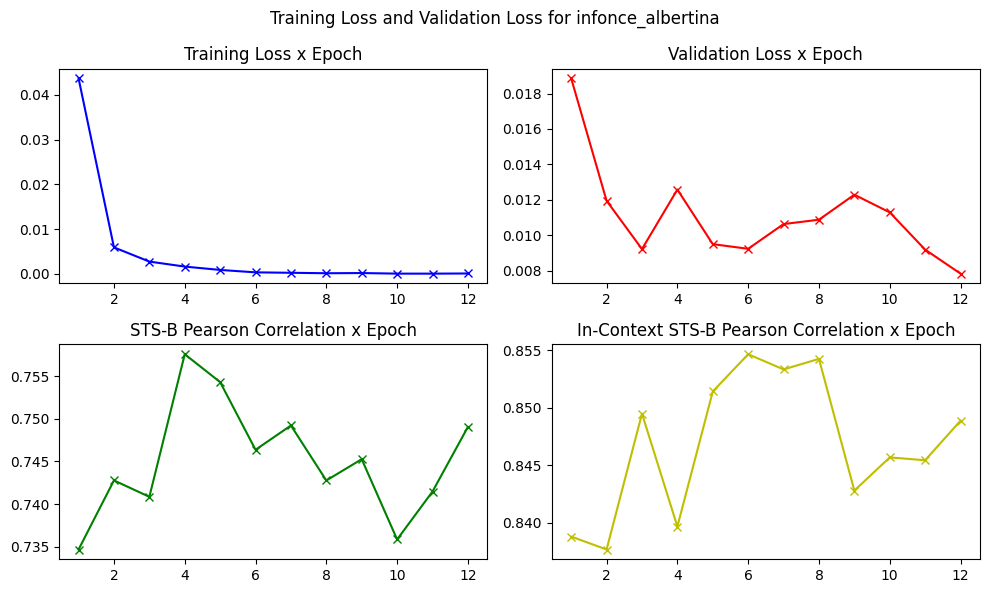

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7351
In-Context STS-B (Pearson): 0.8573
----- TEMPERATURA 0.05 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6805


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0461 | Val Loss: 0.0151 | STS-B: 0.7346 | In-Context STS-B: 0.8403


Epoch:   8%|█▌                 | 1/12 [28:03<5:08:38, 1683.48s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0084 | Val Loss: 0.0075 | STS-B: 0.7504 | In-Context STS-B: 0.8430


Epoch:  17%|███▏               | 2/12 [56:07<4:40:37, 1683.73s/it]

New best model found!


Epoch:  25%|████▎            | 3/12 [1:24:10<4:12:32, 1683.60s/it]

Epoch 3/12 | Train Loss: 0.0027 | Val Loss: 0.0098 | STS-B: 0.7484 | In-Context STS-B: 0.8432


Epoch:  33%|█████▋           | 4/12 [1:52:11<3:44:19, 1682.42s/it]

Epoch 4/12 | Train Loss: 0.0018 | Val Loss: 0.0065 | STS-B: 0.7424 | In-Context STS-B: 0.8506
Epoch 5/12 | Train Loss: 0.0006 | Val Loss: 0.0065 | STS-B: 0.7565 | In-Context STS-B: 0.8471


Epoch:  42%|███████          | 5/12 [2:20:14<3:16:18, 1682.71s/it]

New best model found!


Epoch:  50%|████████▌        | 6/12 [2:48:14<2:48:11, 1681.89s/it]

Epoch 6/12 | Train Loss: 0.0005 | Val Loss: 0.0059 | STS-B: 0.7451 | In-Context STS-B: 0.8470
Epoch 7/12 | Train Loss: 0.0004 | Val Loss: 0.0057 | STS-B: 0.7618 | In-Context STS-B: 0.8536


Epoch:  58%|█████████▉       | 7/12 [3:16:19<2:20:13, 1682.64s/it]

New best model found!


Epoch:  67%|███████████▎     | 8/12 [3:44:21<1:52:10, 1682.68s/it]

Epoch 8/12 | Train Loss: 0.0004 | Val Loss: 0.0053 | STS-B: 0.7505 | In-Context STS-B: 0.8564


Epoch:  75%|████████████▊    | 9/12 [4:12:23<1:24:07, 1682.46s/it]

Epoch 9/12 | Train Loss: 0.0001 | Val Loss: 0.0044 | STS-B: 0.7539 | In-Context STS-B: 0.8534


Epoch:  83%|███████████████   | 10/12 [4:40:26<56:05, 1682.52s/it]

Epoch 10/12 | Train Loss: 0.0001 | Val Loss: 0.0047 | STS-B: 0.7475 | In-Context STS-B: 0.8525


Epoch:  92%|████████████████▌ | 11/12 [5:08:29<28:02, 1682.52s/it]

Epoch 11/12 | Train Loss: 0.0001 | Val Loss: 0.0034 | STS-B: 0.7536 | In-Context STS-B: 0.8538


Epoch: 100%|██████████████████| 12/12 [5:36:30<00:00, 1682.55s/it]

Epoch 12/12 | Train Loss: 0.0000 | Val Loss: 0.0033 | STS-B: 0.7434 | In-Context STS-B: 0.8524


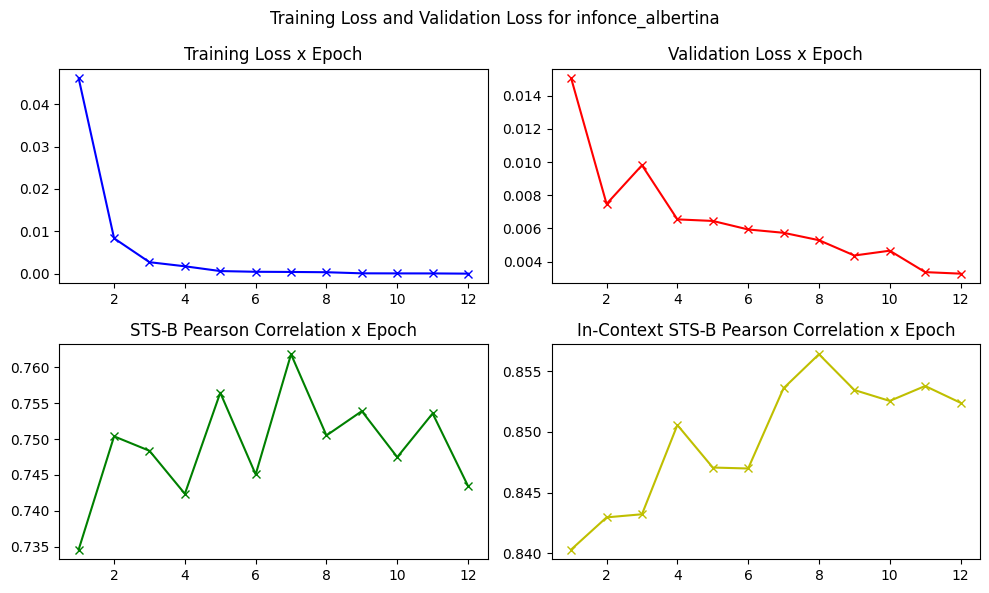

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7494
In-Context STS-B (Pearson): 0.8775
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6964


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0775 | Val Loss: 0.0170 | STS-B: 0.7620 | In-Context STS-B: 0.8429


Epoch:   8%|█▌                 | 1/12 [28:04<5:08:52, 1684.78s/it]

New best model found!


Epoch:  17%|███▏               | 2/12 [56:07<4:40:37, 1683.76s/it]

Epoch 2/12 | Train Loss: 0.0171 | Val Loss: 0.0127 | STS-B: 0.7568 | In-Context STS-B: 0.8413


Epoch:  25%|████▎            | 3/12 [1:24:09<4:12:24, 1682.74s/it]

Epoch 3/12 | Train Loss: 0.0081 | Val Loss: 0.0123 | STS-B: 0.7548 | In-Context STS-B: 0.8460


Epoch:  33%|█████▋           | 4/12 [1:52:10<3:44:17, 1682.24s/it]

Epoch 4/12 | Train Loss: 0.0053 | Val Loss: 0.0114 | STS-B: 0.7286 | In-Context STS-B: 0.8457


Epoch:  42%|███████          | 5/12 [2:20:14<3:16:20, 1682.90s/it]

Epoch 5/12 | Train Loss: 0.0034 | Val Loss: 0.0133 | STS-B: 0.7145 | In-Context STS-B: 0.8385


Epoch:  50%|████████▌        | 6/12 [2:48:21<2:48:24, 1684.12s/it]

Epoch 6/12 | Train Loss: 0.0027 | Val Loss: 0.0093 | STS-B: 0.7118 | In-Context STS-B: 0.8311


Epoch:  50%|████████▌        | 6/12 [3:16:25<3:16:25, 1964.31s/it]

Epoch 7/12 | Train Loss: 0.0020 | Val Loss: 0.0104 | STS-B: 0.7140 | In-Context STS-B: 0.8289
Early stopping!


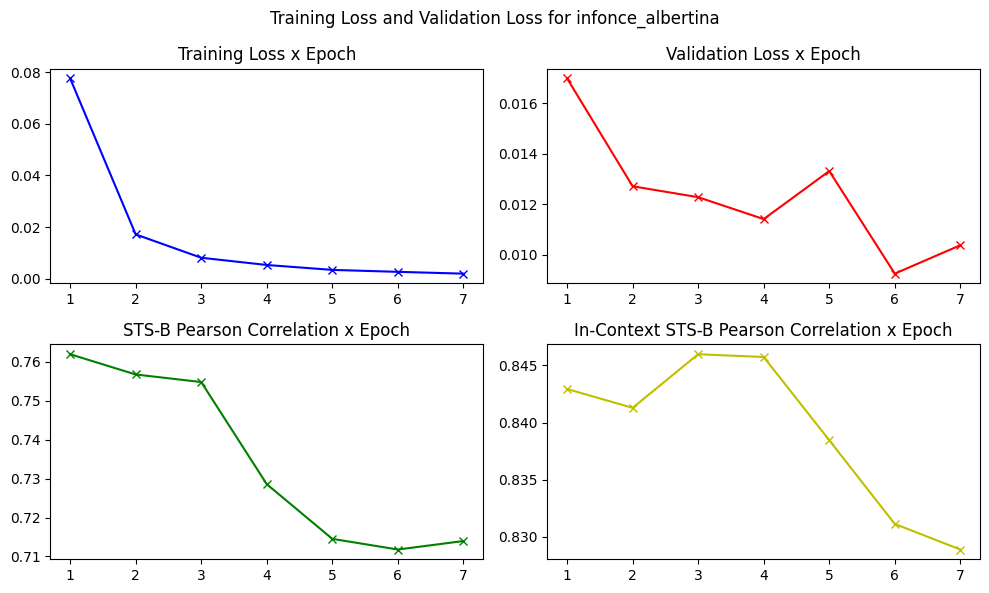

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7439
In-Context STS-B (Pearson): 0.8392
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.7045


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0786 | Val Loss: 0.0084 | STS-B: 0.7618 | In-Context STS-B: 0.8575


Epoch:   8%|█▌                 | 1/12 [28:02<5:08:25, 1682.31s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0172 | Val Loss: 0.0074 | STS-B: 0.7601 | In-Context STS-B: 0.8604


Epoch:  17%|███▏               | 2/12 [56:04<4:40:25, 1682.51s/it]

New best model found!


Epoch:  25%|████▎            | 3/12 [1:24:07<4:12:21, 1682.35s/it]

Epoch 3/12 | Train Loss: 0.0089 | Val Loss: 0.0065 | STS-B: 0.7571 | In-Context STS-B: 0.8585


Epoch:  33%|█████▋           | 4/12 [1:52:07<3:44:12, 1681.59s/it]

Epoch 4/12 | Train Loss: 0.0054 | Val Loss: 0.0062 | STS-B: 0.7552 | In-Context STS-B: 0.8598


Epoch:  42%|███████          | 5/12 [2:20:09<3:16:11, 1681.61s/it]

Epoch 5/12 | Train Loss: 0.0037 | Val Loss: 0.0062 | STS-B: 0.7454 | In-Context STS-B: 0.8588


Epoch:  50%|████████▌        | 6/12 [2:48:11<2:48:11, 1681.86s/it]

Epoch 6/12 | Train Loss: 0.0026 | Val Loss: 0.0068 | STS-B: 0.7452 | In-Context STS-B: 0.8535


Epoch:  58%|█████████▉       | 7/12 [3:16:14<2:20:10, 1682.17s/it]

Epoch 7/12 | Train Loss: 0.0019 | Val Loss: 0.0064 | STS-B: 0.7420 | In-Context STS-B: 0.8529


Epoch:  67%|███████████▎     | 8/12 [3:44:16<1:52:08, 1682.21s/it]

Epoch 8/12 | Train Loss: 0.0015 | Val Loss: 0.0054 | STS-B: 0.7296 | In-Context STS-B: 0.8501


Epoch:  75%|████████████▊    | 9/12 [4:12:17<1:24:05, 1681.90s/it]

Epoch 9/12 | Train Loss: 0.0012 | Val Loss: 0.0056 | STS-B: 0.7284 | In-Context STS-B: 0.8408


Epoch:  75%|████████████▊    | 9/12 [4:40:18<1:33:26, 1868.77s/it]

Epoch 10/12 | Train Loss: 0.0010 | Val Loss: 0.0058 | STS-B: 0.7316 | In-Context STS-B: 0.8405
Early stopping!


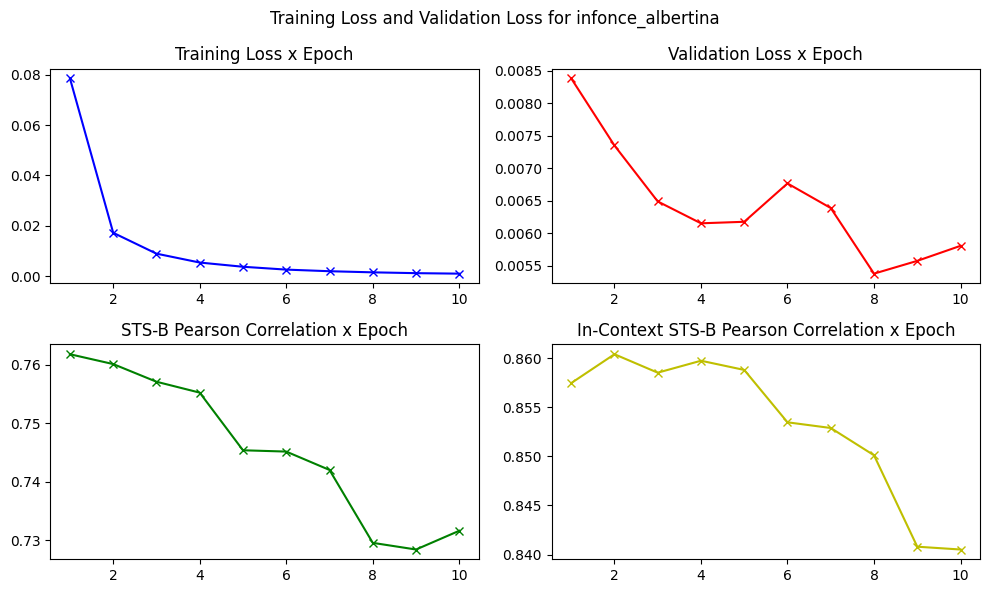

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7360
In-Context STS-B (Pearson): 0.8396
----- TEMPERATURA 0.1 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6794


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.0754 | Val Loss: 0.0121 | STS-B: 0.7496 | In-Context STS-B: 0.8375


Epoch:   8%|█▌                 | 1/12 [28:03<5:08:34, 1683.12s/it]

New best model found!
Epoch 2/12 | Train Loss: 0.0165 | Val Loss: 0.0123 | STS-B: 0.7590 | In-Context STS-B: 0.8441


Epoch:  17%|███▏               | 2/12 [56:05<4:40:28, 1682.86s/it]

New best model found!


Epoch:  25%|████▎            | 3/12 [1:24:08<4:12:26, 1682.97s/it]

Epoch 3/12 | Train Loss: 0.0085 | Val Loss: 0.0109 | STS-B: 0.7548 | In-Context STS-B: 0.8428


Epoch:  33%|█████▋           | 4/12 [1:52:12<3:44:25, 1683.17s/it]

Epoch 4/12 | Train Loss: 0.0054 | Val Loss: 0.0091 | STS-B: 0.7464 | In-Context STS-B: 0.8377


Epoch:  42%|███████          | 5/12 [2:20:19<3:16:31, 1684.52s/it]

Epoch 5/12 | Train Loss: 0.0036 | Val Loss: 0.0090 | STS-B: 0.7533 | In-Context STS-B: 0.8346


Epoch:  50%|████████▌        | 6/12 [2:48:26<2:48:32, 1685.39s/it]

Epoch 6/12 | Train Loss: 0.0026 | Val Loss: 0.0078 | STS-B: 0.7361 | In-Context STS-B: 0.8326


Epoch:  58%|█████████▉       | 7/12 [3:16:35<2:20:33, 1686.70s/it]

Epoch 7/12 | Train Loss: 0.0020 | Val Loss: 0.0075 | STS-B: 0.7396 | In-Context STS-B: 0.8286


Epoch:  58%|█████████▉       | 7/12 [3:44:44<2:40:31, 1926.35s/it]

Epoch 8/12 | Train Loss: 0.0016 | Val Loss: 0.0071 | STS-B: 0.7183 | In-Context STS-B: 0.8264
Early stopping!


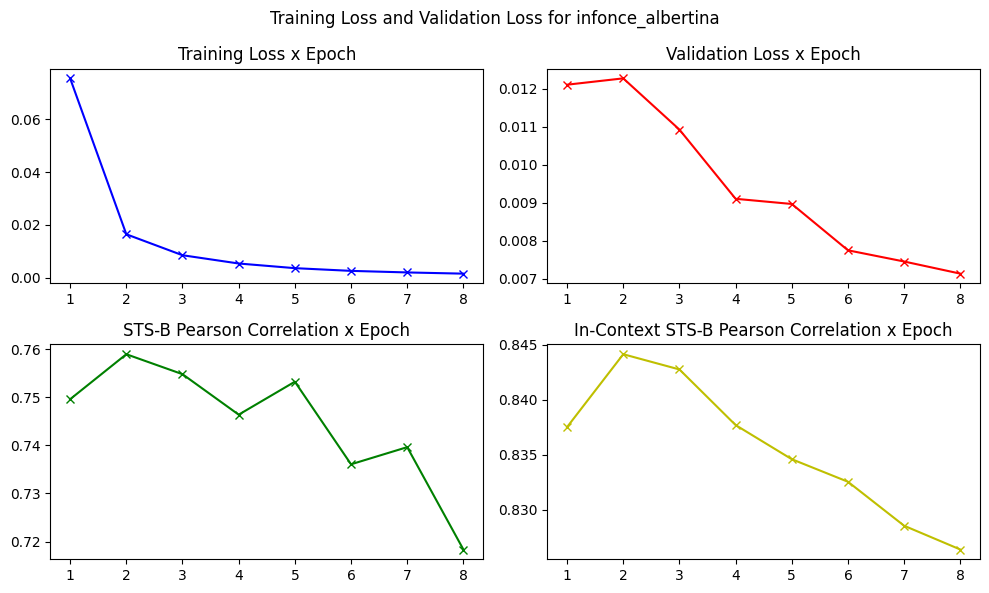

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7317
In-Context STS-B (Pearson): 0.8473
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6910


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.2565 | Val Loss: 0.0235 | STS-B: 0.7214 | In-Context STS-B: 0.8045


Epoch:   8%|█▌                 | 1/12 [28:30<5:13:38, 1710.74s/it]

New best model found!


Epoch:  17%|███▏               | 2/12 [56:35<4:42:31, 1695.16s/it]

Epoch 2/12 | Train Loss: 0.1143 | Val Loss: 0.0218 | STS-B: 0.7098 | In-Context STS-B: 0.7837


Epoch:  25%|████▎            | 3/12 [1:24:40<4:13:36, 1690.68s/it]

Epoch 3/12 | Train Loss: 0.0881 | Val Loss: 0.0160 | STS-B: 0.6969 | In-Context STS-B: 0.7787


Epoch:  25%|████▎            | 3/12 [1:52:45<5:38:17, 2255.24s/it]

Epoch 4/12 | Train Loss: 0.0747 | Val Loss: 0.0137 | STS-B: 0.6972 | In-Context STS-B: 0.7730
Early stopping!


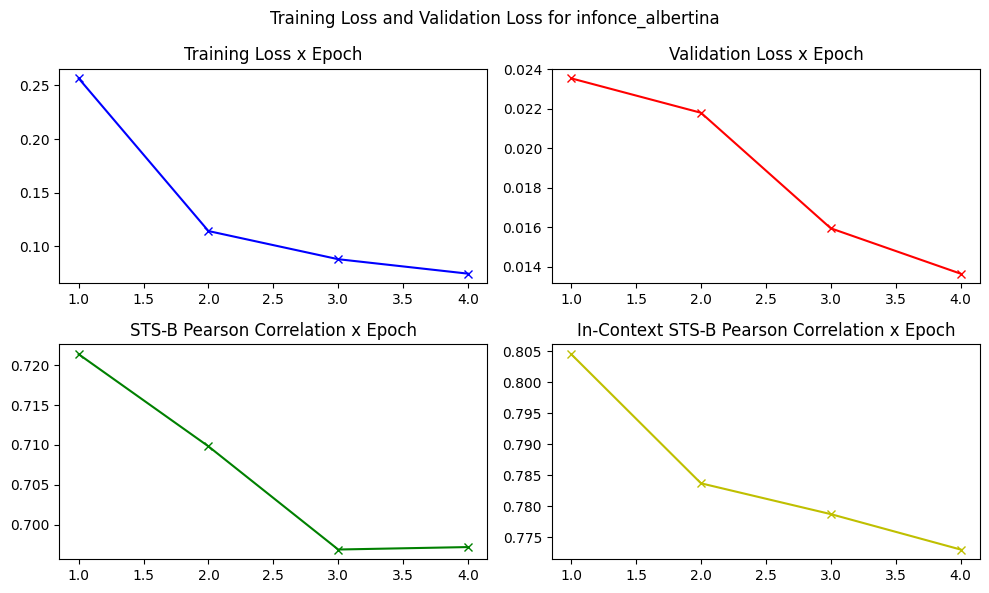

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7000
In-Context STS-B (Pearson): 0.7917
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6889


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.2548 | Val Loss: 0.0137 | STS-B: 0.7335 | In-Context STS-B: 0.8011


Epoch:   8%|█▌                 | 1/12 [28:05<5:09:02, 1685.71s/it]

New best model found!


Epoch:  17%|███▏               | 2/12 [56:08<4:40:39, 1683.96s/it]

Epoch 2/12 | Train Loss: 0.1160 | Val Loss: 0.0096 | STS-B: 0.7193 | In-Context STS-B: 0.7852


Epoch:  25%|████▎            | 3/12 [1:24:10<4:12:28, 1683.14s/it]

Epoch 3/12 | Train Loss: 0.0896 | Val Loss: 0.0139 | STS-B: 0.7033 | In-Context STS-B: 0.7851


Epoch:  33%|█████▋           | 4/12 [1:52:15<3:44:29, 1683.72s/it]

Epoch 4/12 | Train Loss: 0.0755 | Val Loss: 0.0161 | STS-B: 0.6913 | In-Context STS-B: 0.7750


Epoch:  33%|█████▋           | 4/12 [2:20:17<4:40:35, 2104.49s/it]

Epoch 5/12 | Train Loss: 0.0674 | Val Loss: 0.0140 | STS-B: 0.6687 | In-Context STS-B: 0.7745
Early stopping!


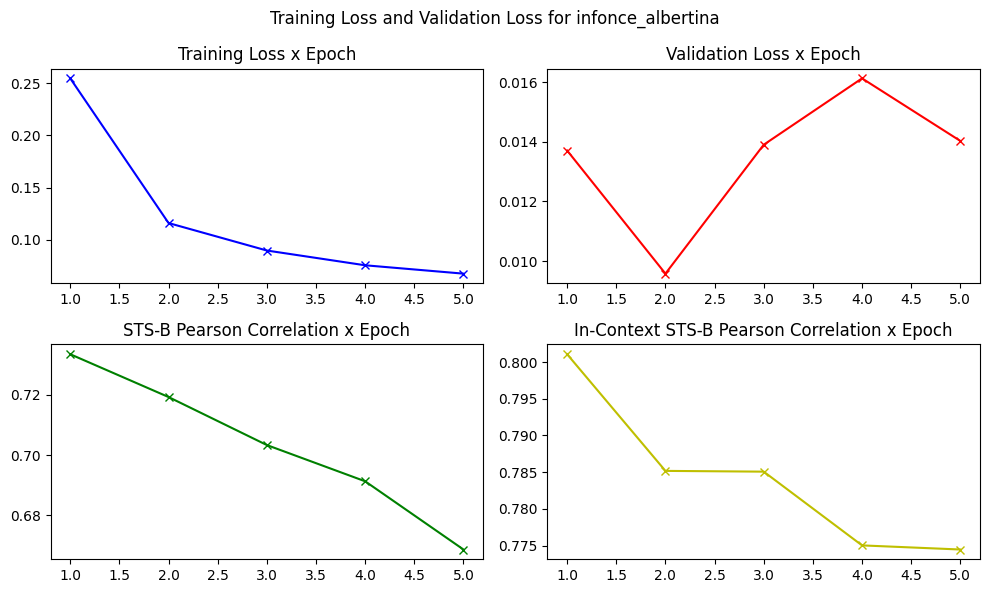

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7175
In-Context STS-B (Pearson): 0.7813
----- TEMPERATURA 0.2 -----
Initial STS-B: 0.6885 | Initial In-Context STS-B: 0.6854


Epoch:   0%|                               | 0/12 [00:00<?, ?it/s]

Epoch 1/12 | Train Loss: 0.2559 | Val Loss: 0.0138 | STS-B: 0.7351 | In-Context STS-B: 0.7873


Epoch:   8%|█▌                 | 1/12 [28:02<5:08:27, 1682.51s/it]

New best model found!


Epoch:  17%|███▏               | 2/12 [56:04<4:40:19, 1681.92s/it]

Epoch 2/12 | Train Loss: 0.1173 | Val Loss: 0.0123 | STS-B: 0.7072 | In-Context STS-B: 0.7715


Epoch:  25%|████▎            | 3/12 [1:24:05<4:12:14, 1681.57s/it]

Epoch 3/12 | Train Loss: 0.0902 | Val Loss: 0.0096 | STS-B: 0.7043 | In-Context STS-B: 0.7604


Epoch:  25%|████▎            | 3/12 [1:52:06<5:36:20, 2242.30s/it]

Epoch 4/12 | Train Loss: 0.0762 | Val Loss: 0.0099 | STS-B: 0.6865 | In-Context STS-B: 0.7551
Early stopping!


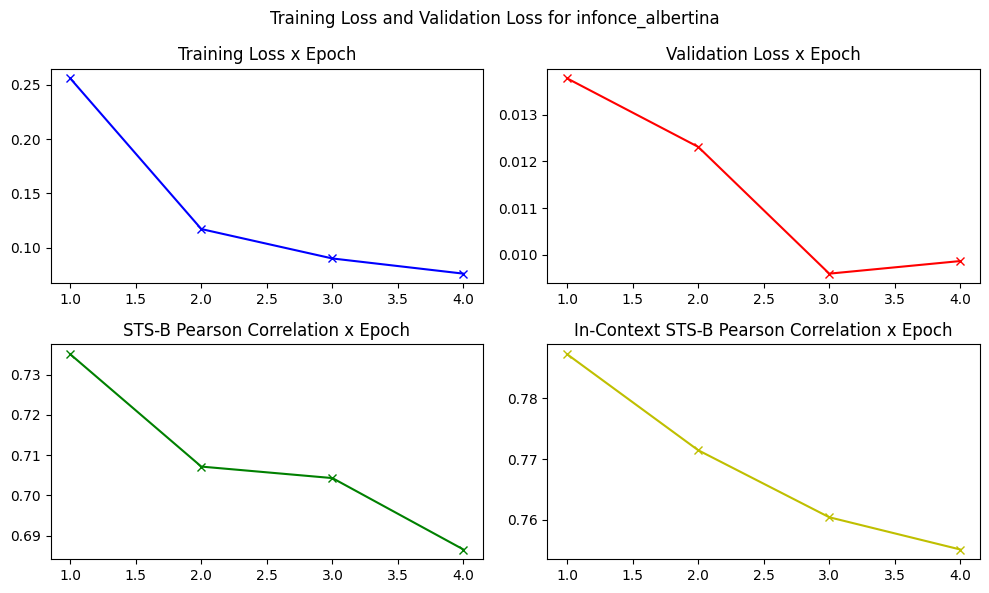

/tmp/ipykernel_1397029/2450432078.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \


STS-B (Pearson): 0.7202
In-Context STS-B (Pearson): 0.7843


In [47]:
# Testing multiple times with multiple temperatures to better evaluate model's performance
# temperatures = [0.05 for i in range(3)] + [0.1 for i in range(3)] + [0.2 for i in range(3)]

# for temp in temperatures:
#     print(f'----- TEMPERATURA {temp} -----')

# Restarting baseline model so not to get the already fine-tuned from previous method or run
base_model = AutoModel.from_pretrained('PORTULAN/albertina-100m-portuguese-ptbr-encoder')

# Initializing InfoNCEModel model and auxiliar variables
model = InfoNCEModel(base_model, tokenizer.pad_token_id, device, hidden_dim=768, proj_dim=768)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
epochs = 12
temperature = 0.03
patience = max(3, math.ceil(epochs*0.1))
model_name = 'infonce_albertina'

# Getting sentences' dataset, dataloader and splits again (now for a supervised dataset)
max_length = 64
text_dataset = SupervisedTextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)
split_batch_size = 4
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
infonce_indices, infonce_embeddings, \
train_losses, val_losses, stsb_track, \
in_context_stsb_track = infonce_training_loop(model, tokenizer, optimizer, train_dataloader, \
                                              val_dataloader, text_dataset_splits[-1], \
                                              ind_df, device, epochs, temperature, patience, \
                                              model_name)

plot_training_curves(train_losses, val_losses, stsb_track, in_context_stsb_track, model_name)

# Loading best model
model.load_state_dict(torch.load(f'../data/models_weights/{model_name}.pth', \
                                 map_location=device)['model_state_dict'])

# Re-checking model's scores after fine-tuning for comparison
_ = stsb_test(model, device, tokenizer, max_length=max_length, model_loss='infonce', \
              verbose=True, train_split=False)

subset = text_dataset_splits[-1]
positional_indices = subset.indices
test_indices = subset.dataset.df.index[positional_indices].tolist()
test_df = ind_df.loc[test_indices, ['descricao_resumida', 'positive_contrastive', \
                                'single_negative_contrastive']]
_ = in_context_stsb_test(model, device, tokenizer, test_df, max_length=max_length, \
                         model_loss='infonce', verbose=True, train_split=False)

In [48]:
# Recomputing baseline embedding for fine-tuned model
baseline_input_ids, \
baseline_embedding = get_baseline_embedding(tokenizer.pad_token_id, tokenizer.cls_token_id, \
                                            tokenizer.sep_token_id, max_length, model, \
                                            device, fine_tuned=True)

# Instanciating attribution computation class for fine-tuned model
infonce_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                           baseline_embedding, device, target_type='cos-sim')
infonce_wrapped_model.eval()
lig = LayerIntegratedGradients(infonce_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
infonce_albertina_indices = []
infonce_albertina_embeddings = []
infonce_albertina_attributions = []
for indices, anchor_ids, _, _ in tqdm(text_dataloader):
    # Saving indices
    infonce_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    anchor_ids = anchor_ids.to(device)

    # Computing mean pooling embeddings
    mp_embeddings = get_embeddings(model, tokenizer, anchor_ids, device, fine_tuned=True)
    infonce_albertina_embeddings.append(mp_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, anchor_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, \
                                                          full_batch_size-1), \
                                           model_name='albertina')
    infonce_albertina_attributions.append(attributions)

# Concatenating the batches
infonce_albertina_indices = np.array(infonce_albertina_indices).squeeze(-1)
infonce_albertina_embeddings = np.array(torch.cat(infonce_albertina_embeddings, dim=0))
infonce_albertina_attributions = np.array(torch.cat(infonce_albertina_attributions, dim=0))

100%|█████████████████████| 20964/20964 [1:33:38<00:00,  3.73it/s]


In [49]:
# Getting data projections
infonce_albertina_trimap, infonce_albertina_tsne, \
infonce_albertina_umap = data_projections(infonce_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
infonce_albertina_trimap = normalize(infonce_albertina_trimap, norm_factor)
infonce_albertina_tsne = normalize(infonce_albertina_tsne, norm_factor)
infonce_albertina_umap = normalize(infonce_albertina_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


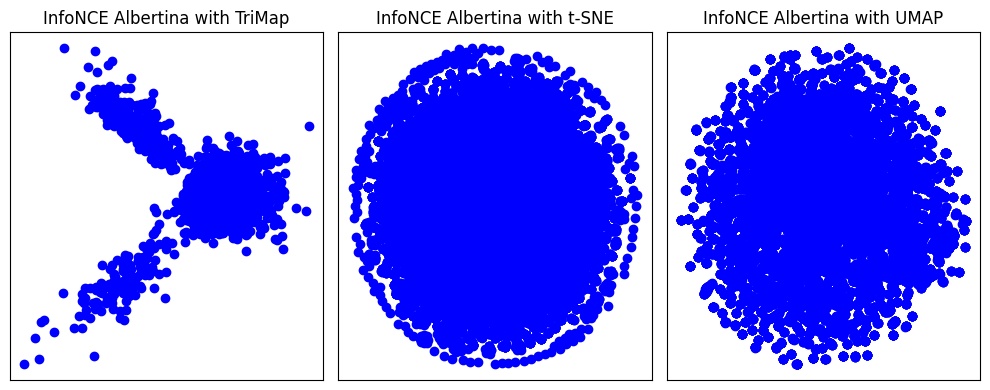

In [50]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting InfoNCE Albertina projections
projs = [infonce_albertina_trimap, infonce_albertina_tsne, infonce_albertina_umap]
proj_names = ['InfoNCE Albertina with TriMap', 'InfoNCE Albertina with t-SNE', \
              'InfoNCE Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [51]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(infonce_albertina_trimap, vanilla_albertina_tokens, \
                   infonce_albertina_attributions, infonce_albertina_indices, \
                   save_file='infonce_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(infonce_albertina_umap, vanilla_albertina_tokens, \
                   infonce_albertina_attributions, infonce_albertina_indices, \
                   save_file='infonce_albertina_umap.csv')

In [52]:
# Cleaning memory
clean_mem([infonce_albertina_embeddings, infonce_albertina_trimap, infonce_albertina_tsne, \
infonce_albertina_umap, infonce_albertina_attributions, infonce_albertina_indices])